In [160]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier 
import pickle
import gzip
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns

# Training matrix: base presence-absence table 

In [161]:
training_matrix = pd.read_csv('../data/presence_absence_4083.csv')

# Extract cluster reps to use for PhagePleats search DB

In [4]:
training_matrix['cluster_ID_function'].str.split(':').str[0].to_csv('../data/cluster_reps.csv',index=False)

In [162]:
# Transpose training data so genomes are rows
training_matrix_T = training_matrix.T
training_matrix_T.columns = training_matrix_T.iloc[0]
training_matrix_T = training_matrix_T.drop(training_matrix_T.index[0])

# RED assigned taxonomy metadata

In [163]:
taxa_df = pd.read_csv('../data/RED_taxonomy.csv')

# Train multiple One vs. All (OvA) models

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Merge training features with taxa labels
df = taxa_df.merge(training_matrix_T, left_on='Leaves', right_index=True)

# Training approach:
## 1. Downsample training set

    * Ensures a controlled number of samples per taxon (e.g., 2, 5, 10, ..., 200).

    * Makes performance comparison fair across taxa by normalizing class size.

## 2. Train binary classifiers

    * For each taxon in y_train, trains a binary classifier: "taxon vs all others".

    * Uses RandomForestClassifier with class_weight="balanced" to handle imbalance.

    * Trains this for each taxon above a frequency threshold (i.e., min_taxa_count).

## 3. Benchmarks across training sizes

    * Loops over a range of training sizes to simulate a learning curve.

    * Evaluates performance using:

        -Accuracy

        -Cross-validation accuracy

        -AUROC

        -Precision, Recall, F1 (both positive and negative classes)

## 4. Stores and exports results

    * Saves results as .csv files (classification metrics and feature importances).

    * Outputs per-rank, per-train-size performance, enabling comparative plots.



# 1. Create train and test sets

In [8]:
def filter_low_count_taxa(df, rank, min_count=5):
    """
    Filters the input DataFrame to include only taxa at the specified rank
    with at least `min_count` instances.

    Parameters:
        df (pd.DataFrame): The DataFrame with the taxon column.
        rank (str): The column name representing the taxonomic rank.
        min_count (int): Minimum number of samples per taxon to keep.

    Returns:
        pd.DataFrame: Filtered DataFrame with only valid taxa.
    """
    counts = df[rank].value_counts()
    valid_taxa = counts[counts >= min_count].index
    return df[df[rank].isin(valid_taxa)].copy()

In [9]:
# Split training and test.....
def create_train_test(df, training_matrix_T, rank='Order'):
    df = df.dropna(subset=[rank], axis=0)
    X = df[training_matrix_T.columns]
    y = df[rank]
    # Split data into train (80%) and test (20%) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

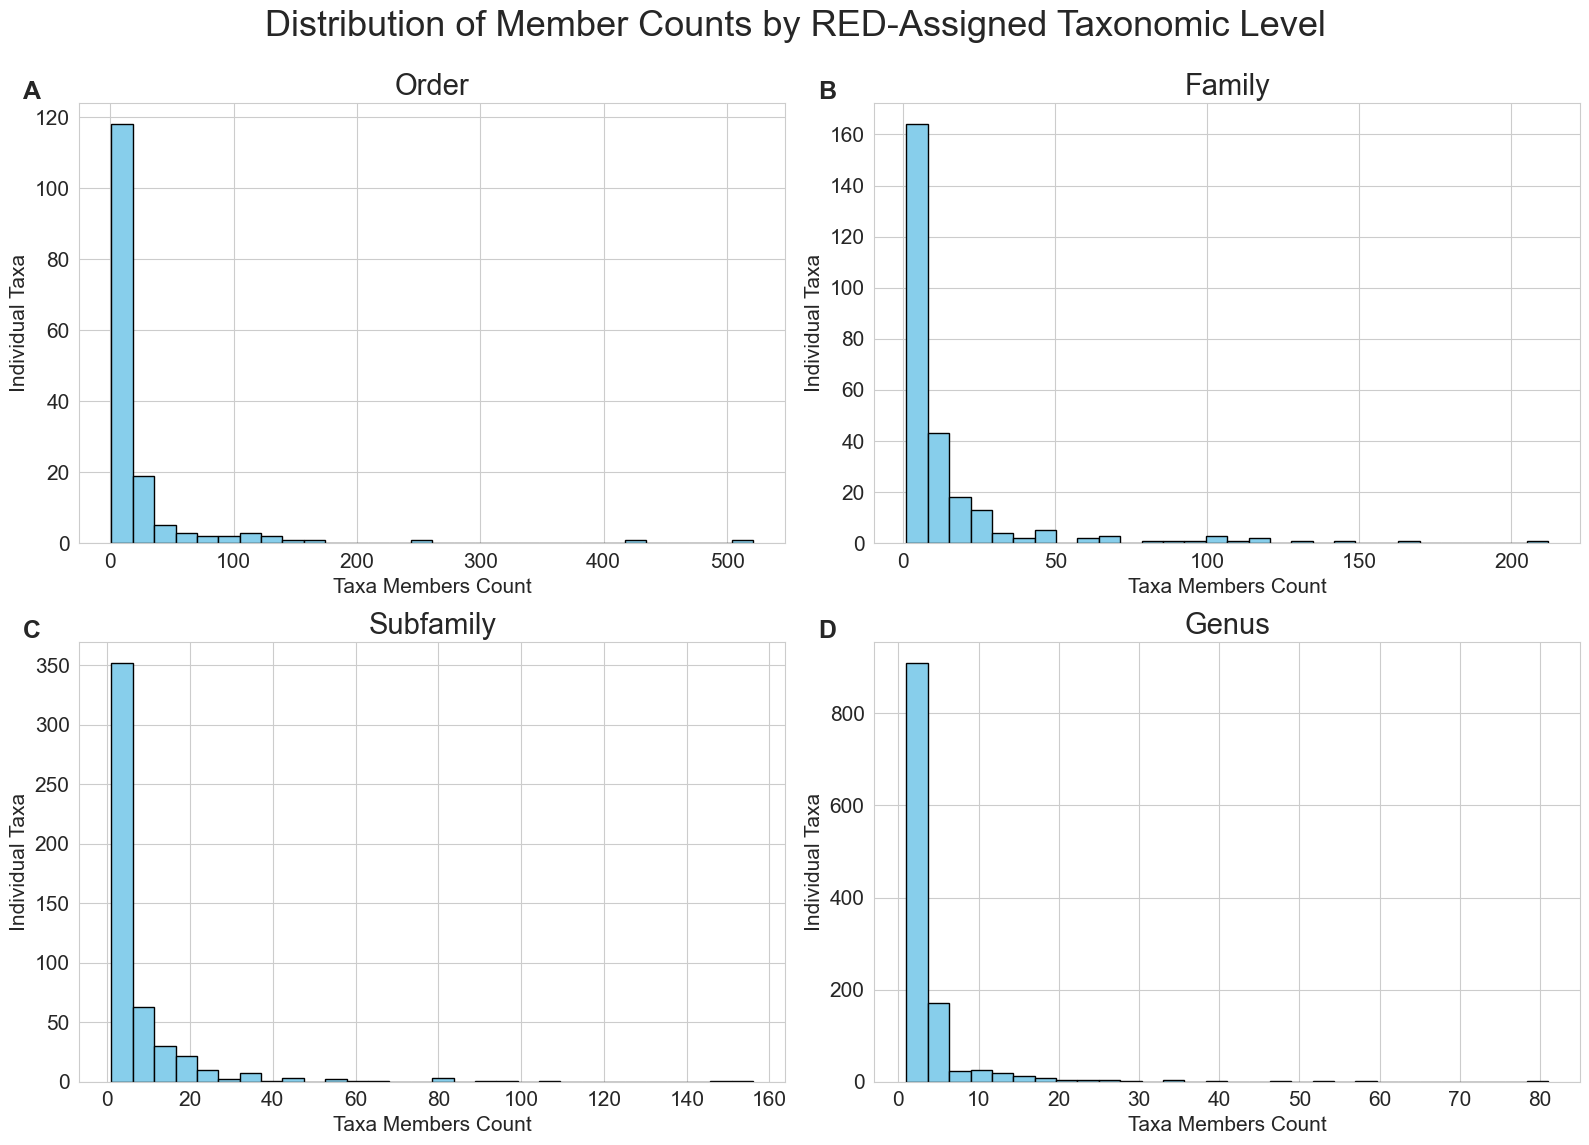

In [50]:
sns.set_style('whitegrid')

tax_levels = ['Order', 'Family', 'Subfamily', 'Genus']
panel_labels = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  
axes = axes.flatten()

for i, level in enumerate(tax_levels):
    counts = df.groupby(level)['Leaves'].count()
    axes[i].hist(counts, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{level}', fontsize=21)
    axes[i].set_xlabel('Taxa Members Count', fontsize=15)
    axes[i].set_ylabel('Individual Taxa', fontsize=15)
    axes[i].tick_params(axis='both', labelsize=15)
    
    # Add panel label (A, B, C, D)
    axes[i].text(-0.08, 1.05, panel_labels[i], transform=axes[i].transAxes,
                 fontsize=18, fontweight='bold', va='top', ha='left')

fig.suptitle('Distribution of Member Counts by RED-Assigned Taxonomic Level', fontsize=26, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
fig.savefig('../data/plots/taxonomic_member_counts_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

def downsample_taxa(X, y, rank, target_count):
    """
    Downsample only taxa with at least `target_count` instances to exactly that many.
    """
    df = X.copy()
    df[rank] = y  # attach labels
    
    valid_taxa = df[rank].value_counts()
    valid_taxa = valid_taxa[valid_taxa >= target_count].index  # only those with enough samples
    
    df = df[df[rank].isin(valid_taxa)]
    
    df_downsampled = (
        df.groupby(rank)
        .apply(lambda x: x.sample(n=target_count, random_state=42))
        .reset_index(drop=True)
    )
    
    return df_downsampled.drop(columns=[rank]), df_downsampled[rank]

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation accuracy")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_roc_curve(y_test_binary, y_pred_proba, taxon):
    """Plot ROC curve for a given taxon."""
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier (diagonal line)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {taxon}')
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve(y_test_binary, y_pred_proba, taxon):
    precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba)
    ap_score = average_precision_score(y_test_binary, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {taxon}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

def plot_probability_distribution(y_pred_proba, y_true, taxon):
    sns.histplot(y_pred_proba[y_true == 1], bins=20, color="blue", label="Positive Class", kde=True)
    sns.histplot(y_pred_proba[y_true == 0], bins=20, color="red", label="Negative Class", kde=True)
    plt.axvline(0.5, linestyle="--", color="black", label="Decision Threshold")
    plt.legend()
    plt.title(f"Probability Distribution for {taxon}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()

def train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Order'):
    results = []  
    feature_importances_all = {} 
    
    # Calculate median taxa count
    if not min_taxa_count:
        min_taxa_count = int(y_train.value_counts().median())  
    #print(f"Balancing all taxa to {min_taxa_count} instances each.")

    #train_sizes = [5,10,20,30,50,100,200]
    #train_sizes = [5,10,25,50,75,100]
 
    train_sizes = [5, 7, 10, 15, 20,30] 

    # Downsample taxa with counts above median
    for size in train_sizes:
        X_train_balanced, y_train_balanced = downsample_taxa(X_train, y_train, rank, size)
        print(f"Balancing all taxa to {size} instances each.")
        print(f"Balanced Train Shape: {X_train_balanced.shape}, Unique taxa: {y_train_balanced.nunique()}")
        print(f"Y Train Value Counts: {y_train_balanced.value_counts()}")
        
        # Only taxa exactly downsampled to `size`
        taxa_counts = y_train_balanced.value_counts()
        taxa_exact_size = taxa_counts[taxa_counts == size].index

        print(f"Y Train Training Value Counts: {taxa_counts.value_counts()}")

        # Train classifiers for each taxon
        for taxon in tqdm(taxa_exact_size, desc=f"Training {rank} classifiers.."):
            print(f"Training {taxon} vs. rest with size {size}")
    
            y_train_binary = (y_train_balanced == taxon).astype(int)
            y_test_binary = (y_test == taxon).astype(int)
    
            model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
            model.fit(X_train_balanced, y_train_binary)

            # Collect feature importances
            feature_importances = model.feature_importances_
            feature_names = X_train_balanced.columns  
            feature_importance_mapping = dict(zip(feature_names, feature_importances))
            if taxon not in feature_importances_all:
                feature_importances_all[taxon] = []
            feature_importances_all[taxon].append({"Train Size": size, "Importances": feature_importance_mapping})  # ✅ Add training size to feature importances
    
            # Cross-validation
            if y_train_binary.sum() >= 5:
                cross_val_scores = cross_val_score(model, X_train_balanced, y_train_binary, cv=5)
                cross_val_mean = cross_val_scores.mean()
            else:
                cross_val_scores = np.array([np.nan])
                cross_val_mean = np.nan
    
            # Test set evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            try:
                auroc = roc_auc_score(y_test_binary, y_pred_proba) if y_test_binary.sum() > 1 else float('nan')
            except Exception as e:
                print(f"AUROC error: {e}")
                auroc = float('nan')
    
            accuracy = accuracy_score(y_test_binary, y_pred)
            report = classification_report(y_test_binary, y_pred, output_dict=True, zero_division=0)
    
            precision_1 = report.get("1", {}).get("precision", float('nan'))
            recall_1 = report.get("1", {}).get("recall", float('nan'))
            f1_1 = report.get("1", {}).get("f1-score", float('nan'))
    
            precision_0 = report.get("0", {}).get("precision", float('nan'))
            recall_0 = report.get("0", {}).get("recall", float('nan'))
            f1_0 = report.get("0", {}).get("f1-score", float('nan'))
    
            model_dir = f"models/{rank}_bg"
            # os.makedirs(model_dir, exist_ok=True)
            model_filename = f"{model_dir}/{taxon}.pkl"
    
            # with open(model_filename, "wb") as f:
            #     pickle.dump(model, f)
    
            # Store results
            results.append({
                "Train Size": size,
                "Dataset": "focal",
                "Level": rank,
                "Taxon": taxon,
                "Training_Leaves_Count": y_train_binary.sum(),
                "Model_Path": model_filename,
                "Accuracy": accuracy,
                "Cross_Val_Accuracy": cross_val_scores.mean(),
                "AUROC": auroc,
                "Precision_0": precision_0,
                "Recall_0": recall_0,
                "F1_0": f1_0,
                "Precision_1": precision_1,
                "Recall_1": recall_1, 
                "F1_1": f1_1,
                "Average_Precision": average_precision_score(y_test_binary, y_pred_proba)
            })
    
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"../data/classification_models_{rank}_train_sizes.csv", index=False)
    
    # Flatten feature importances
    feature_importances_flat = []
    for taxon, entries in feature_importances_all.items():
        for entry in entries:
            size = entry["Train Size"]
            for feature, importance in entry["Importances"].items():
                feature_importances_flat.append({"Train Size": size, "Taxon": taxon, "Feature": feature, "Importance": importance})

    feature_importances_df = pd.DataFrame(feature_importances_flat)
    feature_importances_df.to_csv(f"../data/feature_importances_{rank}_train_sizes.csv", index=False)
    
    print(f"Models saved and results stored in classification_models_{rank}_train_sizes.csv")
    return results_df, feature_importances_df

In [133]:
from matplotlib.colors import ListedColormap

def plot_training_metrics(results, combined_palette, rank="Family", output_file="training_metrics.png",
                                  bottom_spacing=0.6, num_col_legend=6, bbox_to_anchor1_y=-2.0, bbox_to_anchor2_y=-0.5):
    """
    Generate a two-panel plot:
    1. Left: Stacked bar plot of taxon counts normalized per train size.
    2. Right: Scatter plot of model metrics vs train size, including cross-val accuracy.

    Parameters:
    - results (pd.DataFrame): DataFrame with training results including metrics and taxa information
    - combined_palette (list): List of color hex codes or color names
    - rank (str): Taxonomic rank (e.g., 'Family', 'Order') for dynamic labeling
    - output_file (str): File path to save the plot
    """

    sns.set_style("whitegrid", {
        'axes.edgecolor': 'black',
        'grid.color': 'grey',
        'legend.frameon': True,
        'legend.edgecolor': 'grey',
        'legend.facecolor': 'white'
    })

    # Normalize for stacked bar plot
    results = results.copy()
    results["Normalized"] = results.groupby("Train Size")["Training_Leaves_Count"].transform(lambda x: (x / x.sum()) * 100)
    df_pivot = results.pivot(index="Train Size", columns="Taxon", values="Normalized").fillna(0)

    # Create colormap
    colormap = ListedColormap(combined_palette)

    results = results.rename(columns={"Average_Precision": "Average_Precision_AUPRC"})

    # Metrics to plot (including CV accuracy)
    selected_metrics = ['AUROC', 'Average_Precision_AUPRC', 'F1_1', 'Recall_1', 'Precision_1', 'Cross_Val_Accuracy']

    # Grouped average metrics
    df_grouped = results.groupby("Train Size")[selected_metrics].mean().reset_index()

    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1.4, 1]})
    plt.subplots_adjust(bottom=0.35, wspace=0.3)

    # axes[0].text(-0.12, 1.05, "A", transform=axes[0].transAxes,
    #              fontsize=16, fontweight='bold', va='top', ha='right')
    # axes[1].text(-0.12, 1.05, "B", transform=axes[1].transAxes,
    #              fontsize=16, fontweight='bold', va='top', ha='right')

    #move further to left for subfamily plot..
    axes[0].text(-0.26, 1.05, "A", transform=axes[0].transAxes,
                 fontsize=16, fontweight='bold', va='top', ha='right')
    axes[1].text(-0.26, 1.05, "B", transform=axes[1].transAxes,
                 fontsize=16, fontweight='bold', va='top', ha='right')

    # --- Left plot: Stacked bar chart ---
    df_pivot.plot(kind="bar", stacked=True, colormap=colormap, edgecolor="black", linewidth=0.7, ax=axes[0])
    axes[0].set_title(f"{rank} Training Leaves Taxa Count by Train Size", fontsize=20)
    axes[0].set_xlabel("Train Size", fontsize=14)
    axes[0].set_ylabel("Percentage (%)", fontsize=14)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    axes[0].tick_params(axis='x', labelrotation=0)

    # --- Right plot: Metrics scatter plot ---
    metric_colors = {
        "AUROC": "#0165fc",
        "Average_Precision_AUPRC": "orange",
        "Recall_1": "#65e81a", 
        "Precision_1": "#ED3500",
        "F1_1": "#0D5EA6",
        "Cross_Val_Accuracy": "#B13BFF"
    }
    metric_markers = {
        "AUROC": "X",
        "Average_Precision_AUPRC": "s",
        "Recall_1": "P",
        "Precision_1": "D",
        "F1_1": "^",
        "Cross_Val_Accuracy": "o"
    }

    for metric in selected_metrics:
        jitter = np.random.uniform(-0.4, 0.4, size=len(df_grouped))
        sns.scatterplot(
            x=df_grouped["Train Size"] + jitter,
            y=df_grouped[metric],
            label=metric,
            ax=axes[1],
            s=70,
            color=metric_colors[metric],
            marker=metric_markers[metric],
            edgecolor="black",
            linewidth=0.5
        )

    axes[1].axhline(y=0.95, color="r", linestyle="--", label="95% Threshold")
    axes[1].set_title(f"Training Size vs Model Metrics ({rank} level)", fontsize=20)

    axes[1].set_ylim(0.2, 1.05)
    axes[1].grid(True)
    axes[1].set_xlabel("Train Size", fontsize=14)
    axes[1].set_ylabel("Metric Score", fontsize=14)
    axes[1].tick_params(axis='both', labelsize=14)

    # Legends
    handles1, labels1 = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles1, labels1,
        loc='lower center',
        bbox_to_anchor=(0.5, bbox_to_anchor1_y),
        ncol=num_col_legend,
        fontsize=9,
        title=f"{pluralize_rank(rank)}",
        frameon=True,
        edgecolor='grey'
    )

    handles2, labels2 = axes[1].get_legend_handles_labels()
    axes[1].legend(
        handles2, labels2,
        loc='lower center',
        bbox_to_anchor=(0.5, bbox_to_anchor2_y),
        ncol=2,
        fontsize=12,
        title="Metrics",
        frameon=True,
        edgecolor='grey'
    )

    plt.subplots_adjust(bottom=bottom_spacing)
    plt.tight_layout()
    plt.savefig(output_file, dpi=700, bbox_inches="tight")
    plt.show()

def pluralize_rank(rank):
    if rank.lower() == "order":
        return "Orders"
    elif rank.lower() == "family":
        return "Families"
    elif rank.lower() == "subfamily":
        return "Subfamilies"
    elif rank.lower() == "genus":
        return "Genera"
    else:
        return f"{rank}s"

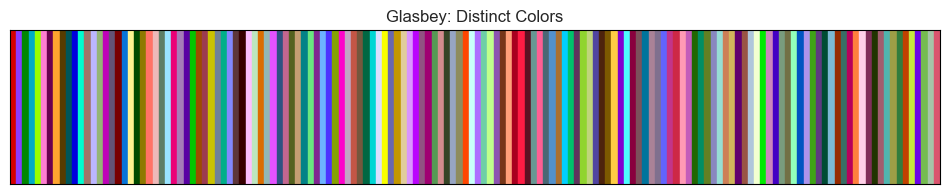

In [81]:
import matplotlib.pyplot as plt
import colorcet as cc

glasbey_palette = list(cc.glasbey[:150])

# Visualize
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(glasbey_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, len(glasbey_palette))
ax.set_yticks([])
ax.set_xticks([])
plt.title("Glasbey: Distinct Colors")
plt.show()

# 1.1. Train downsampled Order and plot performance by train size

In [ ]:
filtered_df = filter_low_count_taxa(df, rank='Order', min_count=5)

X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Order')

order_results, feature_importances_df = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Order')

In [98]:
order_results = pd.read_csv('../data/classifier_performance/classification_models_Order_train_sizes.csv')
#orders_features = pd.read_csv('../data/classifier_performance/feature_importances_Order_train_sizes.csv')

In [6]:
order_results[0:1]

,Train Size,Dataset,Level,Taxon,Training_Leaves_Count,Model_Path,Accuracy,Cross_Val_Accuracy,AUROC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Average_Precision
0,5,focal,Order,Aliceevansvirales,5,models/Order_bg/Aliceevansvirales.pkl,0.987245,0.993617,0.99107,0.986911,1.0,0.993412,1.0,0.666667,0.8,0.937195


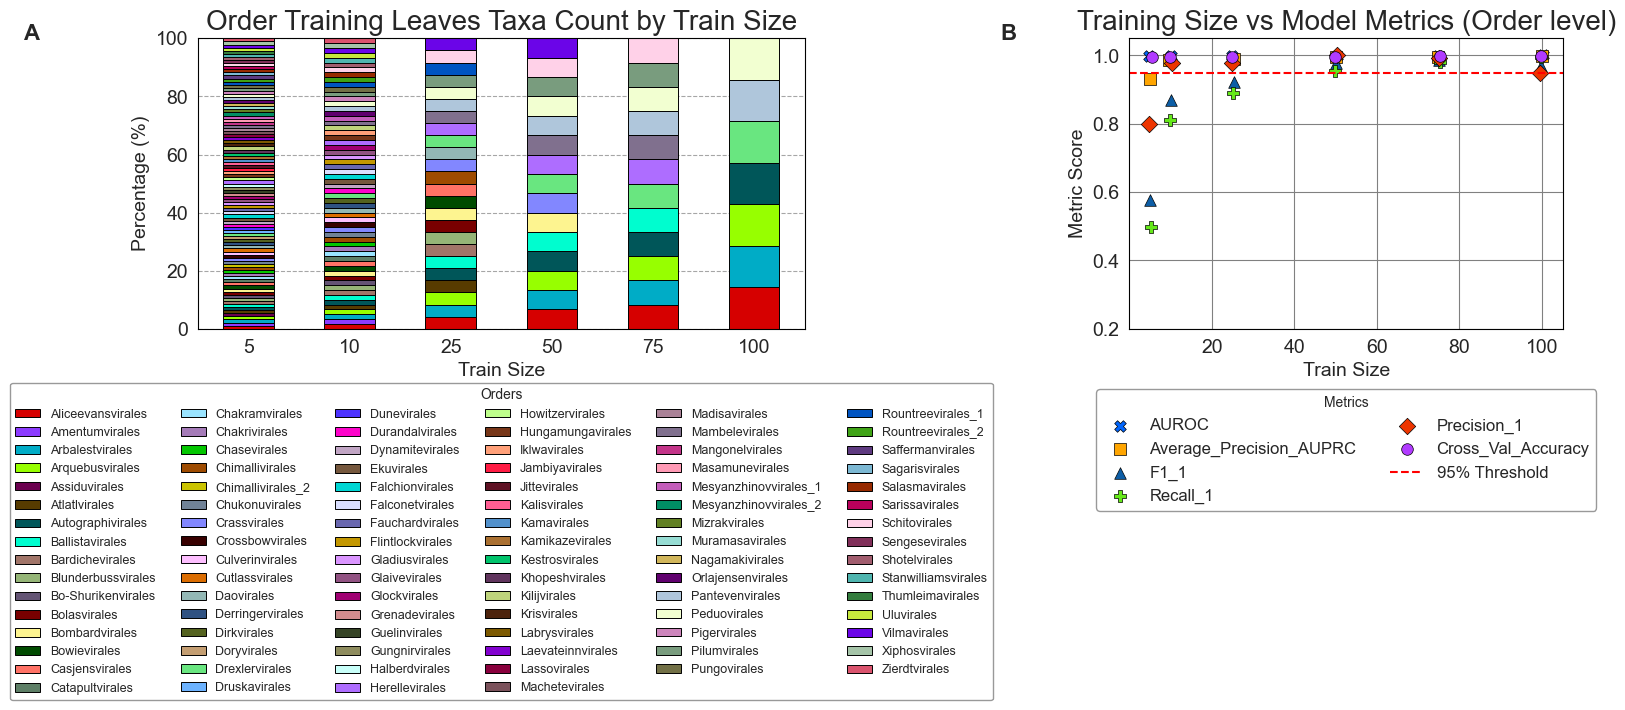

In [134]:
plot_training_metrics(order_results, glasbey_palette, rank="Order", output_file="../data/plots/order_training_metrics.png",
                      bottom_spacing=0.55, num_col_legend=6, bbox_to_anchor1_y=-1.3, bbox_to_anchor2_y=-0.655
                     )

# 1.2. Train downsampled family

In [56]:
filtered_df = filter_low_count_taxa(df, rank='Family', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Family')

In [ ]:
family_results, family_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Family')

In [101]:
family_results = pd.read_csv('../data/classifier_performance/classification_models_Family_train_sizes.csv')
#family_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Family_train_sizes.csv')

In [61]:
family_results.Training_Leaves_Count.unique()

array([  5,  10,  25,  50,  75, 100], dtype=int64)

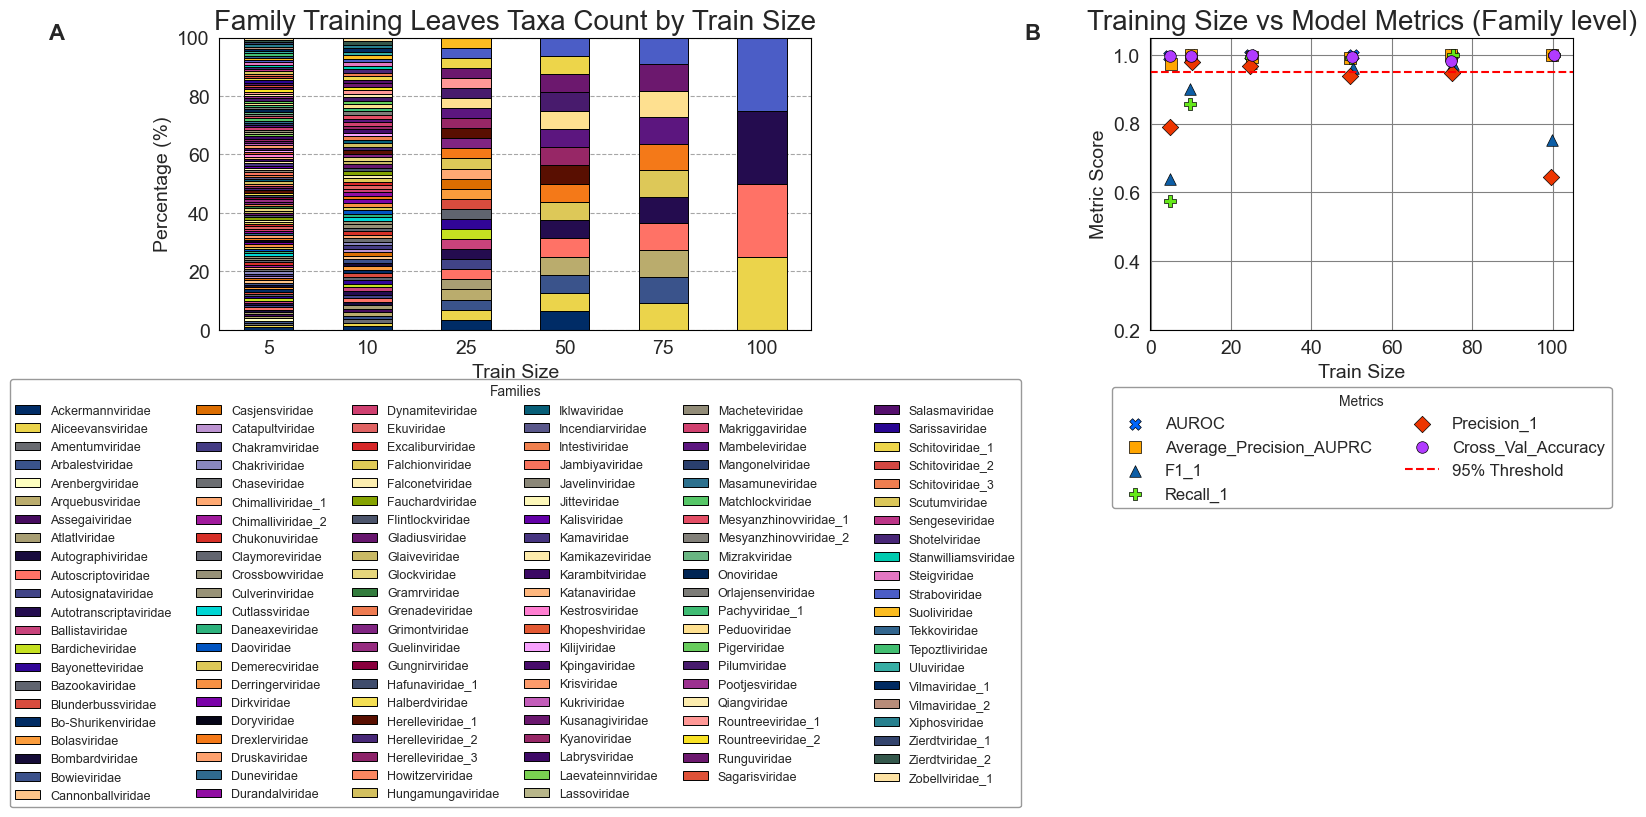

In [135]:
plot_training_metrics(family_results, combined_palette, rank="Family", output_file="../data/plots/family_training_metrics.png",
                      bottom_spacing=0.63, num_col_legend=6, bbox_to_anchor1_y=-1.655, bbox_to_anchor2_y=-0.64
                     )

# 1.3. Subfamily

In [ ]:
filtered_df = filter_low_count_taxa(df, rank='Subfamily', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Subfamily')
subfamily_results, subfamily_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Subfamily')

In [113]:
subfamily_results = pd.read_csv('../data/classifier_performance/classification_models_Subfamily_train_sizes.csv')
#subfamily_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Subfamily_train_sizes.csv')

C:\Users\crtuser\AppData\Local\Temp\ipykernel_9624\2952472248.py:133: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


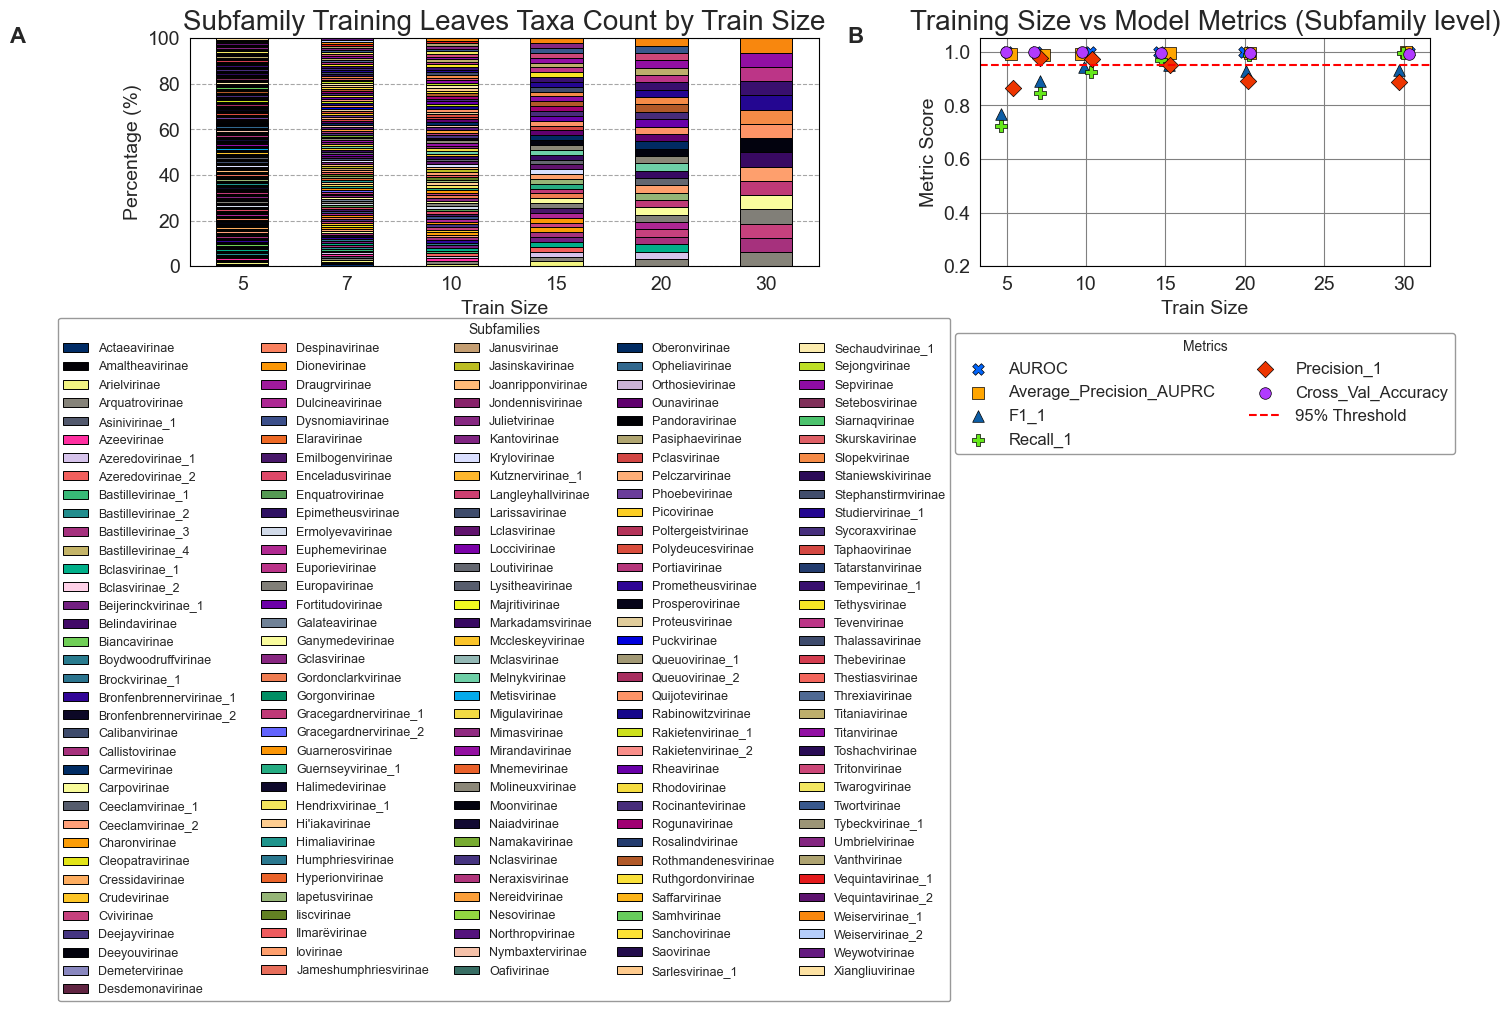

In [136]:
plot_training_metrics(subfamily_results, combined_palette, rank="Subfamily", output_file="../data/plots/subfamily_training_metrics.png",
                      bottom_spacing=0.5, num_col_legend=5, bbox_to_anchor1_y=-3.25, bbox_to_anchor2_y=-0.86
                     )

# 1.4. Genus

In [ ]:
filtered_df = filter_low_count_taxa(df, rank='Genus', min_count=5)
X_train, X_test, y_train, y_test = create_train_test(filtered_df, training_matrix_T, rank='Genus')
genera_results, genera_feature_importance = train_binary_classifiers(X_train, X_test, y_train, y_test, training_matrix_T, min_taxa_count=5, rank='Genus')

In [138]:
genera_results = pd.read_csv('../data/classifier_performance/classification_models_Genus_train_sizes.csv')
#genera_feature_importance = pd.read_csv('../data/classifier_performance/feature_importances_Genus_train_sizes.csv')

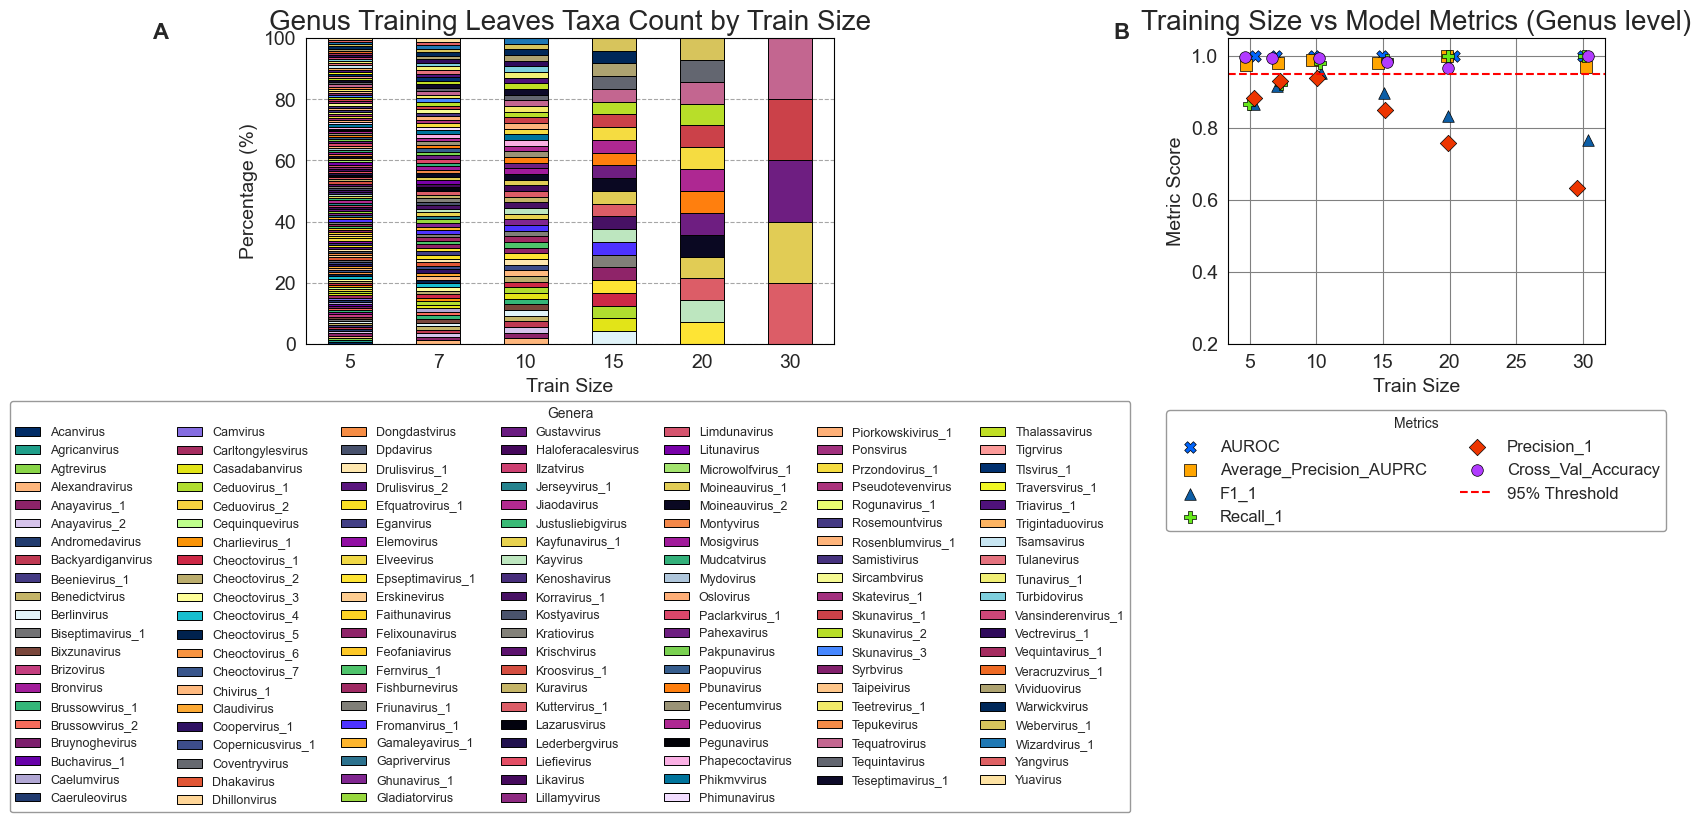

In [158]:
plot_training_metrics(genera_results, combined_palette, rank="Genus", output_file="../data/plots/genus_training_metrics.png",
                      bottom_spacing=0.62, num_col_legend=7, bbox_to_anchor1_y=-1.55, bbox_to_anchor2_y=-0.64
                     )

# 2. Train Production classifiers on all data...

In [28]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def train_classifier(X, y, taxon, rank, model_dir):
    """Train a classifier for a single taxon and save results."""
    print(f"Training classifier for {rank}: {taxon}")
    y_binary = (y[rank] == taxon).astype(int)  # Fix: correctly extract labels

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    model.fit(X, y_binary)

    feature_importances = dict(zip(X.columns, model.feature_importances_))

    model_filename = f"{model_dir}/{taxon}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return {
        "Level": rank,
        "Taxon": taxon,
        "Model_Path": model_filename
    }

def train_production_classifiers(X, y, rank='Order', model_dir=None):
    """Train classifiers on all data for each taxonomic level without splitting."""
    results = []
    feature_importances_all = []

    # Append rank to the base model_dir to create subfolder
    if model_dir is None:
        model_dir = f"models/production/{rank}"
    else:
        model_dir = os.path.join(model_dir, rank)

    os.makedirs(model_dir, exist_ok=True)

    taxa_unique = y[rank].unique()

    print(f"Training classifiers for {rank} on full dataset...")

    parallel_results = Parallel(n_jobs=-1)(
        delayed(train_classifier)(X, y, taxon, rank, model_dir)
        for taxon in tqdm(taxa_unique, desc=f"Training {rank} classifiers")
    )

    results.extend(parallel_results)

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(model_dir, f"classification_models_{rank}.csv"), index=False)

    print(f"Models saved and results stored in {model_dir}")
    return results_df

In [29]:
X = df[training_matrix_T.columns]  # Feature matrix
y = df[['Order']]  # Target labels (must be a DataFrame)

In [30]:
# Drop rows where 'Order' is NaN
X_filtered = X[y['Order'].notna()]
y_filtered = y[y['Order'].notna()]

In [31]:
results_df = train_production_classifiers(X_filtered, 
                                          y_filtered, 
                                          rank='Order', 
                                          model_dir="../data/models/production")

Training classifiers for Order on full dataset...


Training Order classifiers: 100%|████████████████████████████████████████████████████| 159/159 [08:59<00:00,  3.39s/it]


Models saved and results stored in ../data/models/production\Order


In [32]:
X = df[training_matrix_T.columns] 
y = df[['Family']].dropna()  # Drop NaNs from y
X = X.loc[y.index]
results_df = train_production_classifiers(X, y, 
                                          rank='Family',
                                          model_dir="../data/models/production")

Training classifiers for Family on full dataset...


Training Family classifiers: 100%|███████████████████████████████████████████████████| 267/267 [14:45<00:00,  3.32s/it]


Models saved and results stored in ../data/models/production\Family


In [33]:
X = df[training_matrix_T.columns] 
y = df[['Subfamily']].dropna() 
X = X.loc[y.index] 
results_df = train_production_classifiers(X, y, 
                                          rank='Subfamily',
                                          model_dir="../data/models/production")

Training classifiers for Subfamily on full dataset...


Training Subfamily classifiers: 100%|████████████████████████████████████████████████| 502/502 [35:50<00:00,  4.28s/it]


Models saved and results stored in ../data/models/production\Subfamily


In [34]:
X = df[training_matrix_T.columns]
y = df[['Genus']].dropna()
X = X.loc[y.index]
results_df = train_production_classifiers(X, y, 
                                          rank='Genus', 
                                          model_dir="../data/models/production")

Training classifiers for Genus on full dataset...


Training Genus classifiers: 100%|████████████████████████████████████████████████| 1189/1189 [1:24:13<00:00,  4.25s/it]


Models saved and results stored in ../data/models/production\Genus


# 159 orders
# 267 families
# 502 subfamilies
# 1189 genera...

# 3. Get feature importances for all ranks

In [9]:
import os
import pickle
import pandas as pd
from tqdm import tqdm  # progress bar

ranks = ['Order', 'Family', 'Subfamily', 'Genus']
model_base_dir = "../data/models/production"

imp_dfs = {}
X = df[training_matrix_T.columns] 

for rank in ranks:
    print(f"\nLoading models for {rank}...")
    model_dir = os.path.join(model_base_dir, rank)
    model_files = [f for f in os.listdir(model_dir) if f.endswith(".pkl")]

    importance_rows = []

    for file in tqdm(model_files, desc=f"Processing {rank}", unit="model"):
        path = os.path.join(model_dir, file)
        taxon = file.replace(".pkl", "")
        
        with open(path, "rb") as f:
            model = pickle.load(f)
            importances = model.feature_importances_
            imp_series = pd.Series(importances, index=X.columns, name=taxon)
            importance_rows.append(imp_series)

    # Combine into DataFrame
    imp_df = pd.DataFrame(importance_rows)
    imp_dfs[rank] = imp_df


Loading models for Order...


Processing Order: 100%|███████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 28.59model/s]



Loading models for Family...


Processing Family: 100%|██████████████████████████████████████████████████████████| 267/267 [00:07<00:00, 34.40model/s]



Loading models for Subfamily...


Processing Subfamily: 100%|███████████████████████████████████████████████████████| 502/502 [00:13<00:00, 36.08model/s]



Loading models for Genus...


Processing Genus: 100%|█████████████████████████████████████████████████████████| 1189/1189 [00:31<00:00, 37.96model/s]


In [12]:
# Step 1: Compute mean importance per feature for each rank
mean_imp_df = pd.DataFrame({
    rank: imp_dfs[rank].mean() for rank in imp_dfs
}).T  # shape: ranks × features

In [13]:
# Step 2: Select top N features globally (across all ranks)
top_n = 30
top_features = mean_imp_df.max().sort_values(ascending=False).head(top_n).index
mean_imp_top = mean_imp_df[top_features]

In [14]:
# looked up pfam annotations for hypothetical proteins...:
imp_dfs = {
    rank: df.rename(columns={
        'YP_009595775.1:hypothetical protein FDH00_gp17': 'YP_009595775.1:Phage minor tail protein L',
        'YP_010682209.1:hypothetical protein PQE84_gp32': 'YP_010682209.1:Poxvirus A22 protein',
        'YP_009594313.1:hypothetical protein FDG92_gp24':'YP_009594313.1:MGP3 C-terminal domain',
        'WQJ54370.1:MAG: UvsX-like recombinase ':'WQJ54370.1:UvsX-like recombinase'
    })
    for rank, df in imp_dfs.items()
}

In [15]:
def plot_top_features_by_rank(imp_dfs, top_n=10, main_title="Most Predictive Features by Taxonomic Rank"):
    """
    Plot the top N most important features for each taxonomic rank in separate subplots.

    Parameters:
        imp_dfs (dict): Dictionary of {rank: importance_df} with rows = taxa, columns = features.
        top_n (int): Number of top features to show per rank.
        main_title (str): Title for the entire figure.
    """
    n_ranks = len(imp_dfs)
    fig, axes = plt.subplots(1, n_ranks, figsize=(6 * n_ranks, 6), sharey=False)

    if n_ranks == 1:
        axes = [axes]

    for ax, (rank, df) in zip(axes, imp_dfs.items()):
        mean_imp = df.mean()
        top_feats = mean_imp.sort_values(ascending=False).head(top_n)

        sns.barplot(
            x=top_feats.values,
            y=top_feats.index,
            ax=ax,
            color="steelblue"  # Or any single color
        )
        ax.set_title(f"Top {top_n} Features: {rank}")
        ax.set_xlabel("Mean Importance")
        ax.set_ylabel("Feature")

    fig.suptitle(main_title, fontsize=25, weight='normal', y=0.97)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for suptitle
    plt.savefig("../data/plots/classifier_most_predictive_features_by_rank.png", dpi=300)
    plt.show()

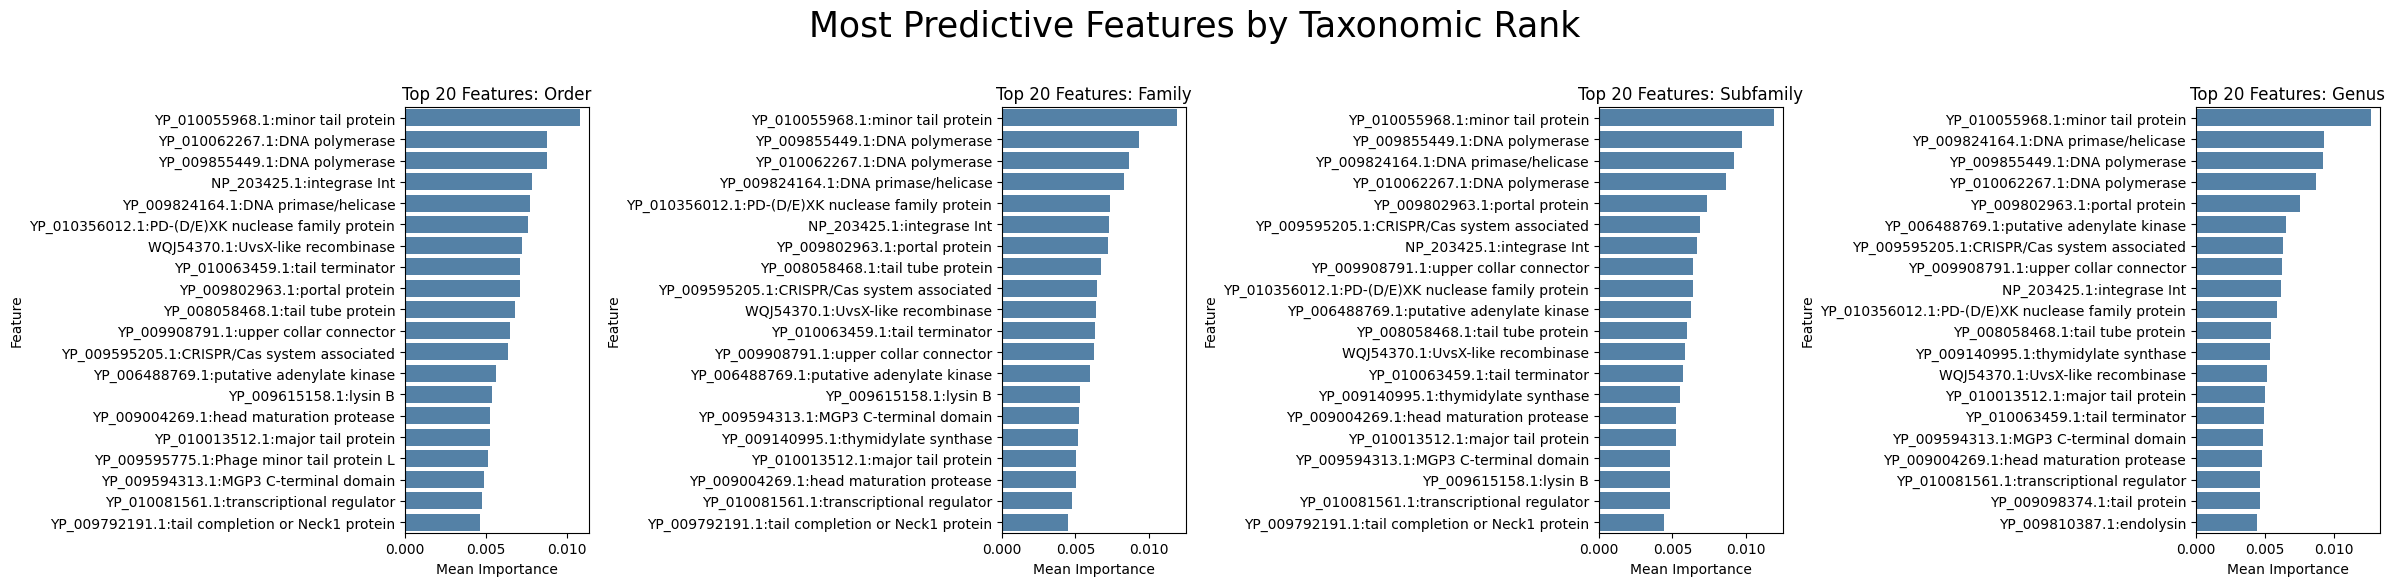

In [16]:
plot_top_features_by_rank(imp_dfs, top_n=20)

In [23]:
def classify_pfam(text):
    text = str(text).lower().replace('–', '-').replace('—', '-')

    if ":" in text:
        text = text.split(":", 1)[-1]

    if any(k in text for k in [
        "major capsid", "capsid", "head", "coat", "scaffold", "portal",
        "tail sheath", "tail tube", "neck", "connector", "virion protein",
        "tegument", "fibritin", "gp5", "gp8", "base plate", "surface protein", "gp10",
        "structural", "nucleocapsid", "baseplate", "fiber", "envelope", "virion",
        "collar", "head-tail joining", "injectosome", "translocase",
        "minor tail protein", "tail terminator", "major tail protein",
        "head maturation protease", "tail length tape measure", "tail completion", "neck1", "tail", "gp77"]):
        return "Structure"

    if any(k in text for k in [
        "terminase", "packaging", "dna packaging", "packaging motor", "gp17"]):
        return "Packaging"

    if any(k in text for k in [
        "toxin", "antitoxin", "toxin-antitoxin", "abortive infection", "abi",
        "restriction-modification", "ocr", "dna mimic", "immunity", "crispr",
        "crispr/cas", "anti-restriction"]):
        return "Defense"

    if any(k in text for k in [
        "polymerase", "helicase", "primase", "ligase", "replication", "replisome",
        "topoisomerase", "gyrase", "endonuclease", "exonuclease", "nuclease",
        "proofreading", "ribonucleotide", "methyltransferase", "uridyl", "mcm",
        "dna polymerase", "rna polymerase", "translation initiation",
        "transcription specificity", "reverse transcriptase", "transcription", "transcriptional",
        "thymidylate synthase", "a22"]):
        return "Replication"

    if any(k in text for k in [
        "integrase", "recombinase", "transposase", "transposon", "resolvase",
        "insertion sequence", "is element", "mu", "serine recombinase",
        "tyrosine recombinase", "giy-yig", "reca", "rect"]):
        return "Mobile Element"

    if any(k in text for k in [
        "holin", "endolysin", "lysin", "spanin", "cell wall degradation",
        "lysis", "muramidase", "rdd", "lysozyme", "amidase",
        "n-acetylmuramoyl", "alanine amidase"]):
        return "Lysis"

    if any(k in text for k in [
        "tail fiber", "tailspike", "rbp", "receptor", "adhesin", "adhesion",
        "host specificity", "tropism", "spike", "gp19", "gp12", "gp37", "gp38", "virulence", "mgp3"]):
        return "Infection"

    if any(k in text for k in [
        "channel", "porin", "transport", "permease", "symporter", "antiporter",
        "abc transporter"]):
        return "Transport"

    if any(k in text for k in [
        "kinase", "phosphatase", "oxidase", "dehydrogenase", "isomerase",
        "hydrolase", "enzyme", "transferase"]):
        return "Metabolism"

    if any(k in text for k in [
        "repressor", "activator", "regulator", "zinc finger", "helix-turn-helix",
        "ht-h", "sant", "marr", "sam-like", "ribbon-helix-helix"]):
        return "Regulation"

    if any(k in text for k in [
        "sensor", "response regulator", "histidine kinase", "quorum sensing",
        "chemotaxis", "two-component"]):
        return "Signaling"

    if any(k in text for k in [
        "ribosome", "ribosomal", "translation", "elongation factor",
        "initiation factor", "termination factor"]):
        return "Translation"

    if any(k in text for k in [
        "immune evasion", "vif", "tat", "modulator", "interferon", "bcl",
        "host interaction", "virulence factor"]):
        return "Host_modulation"

    if any(k in text for k in [
        "hypothetical", "unknown", "uncharacterised", "uncharacterized", "duf", "upf",
        "domain of unknown function", "family of unknown function"]):
        return "Unknown/Other"

    return "Unknown/Other"

In [24]:
# ok this one is perfect....!!!@!
def plot_siamcat_style_interpretation(imp_dfs, top_n=30):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import matplotlib.colors as mcolors


    from matplotlib.colors import BoundaryNorm, ListedColormap

    # Custom value breaks (e.g., like "<0.1%", "0.1–0.25%", etc.)
    value_breaks = [0, 0.0005, 0.001, 0.0025, 0.005, 0.008, 0.010, 0.0135]  # final upper edge slightly above max
    
    # Matching green shades (light → dark)
    colors = ["#f7fcf5", "#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", "#31a354", "#006d2c"]
    
    # Create colormap and normalization
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(value_breaks, ncolors=len(colors), clip=True)

    sns.set_style('ticks')

    # Step 1: Mean feature importance per rank
    mean_imp = {rank: df.mean(axis=0) for rank, df in imp_dfs.items()}
    imp_matrix = pd.DataFrame(mean_imp)

    # Step 2: Select top N features overall
    top_feats = imp_matrix.mean(axis=1).sort_values(ascending=False).head(top_n).index
    imp_top = imp_matrix.loc[top_feats]

    # # # Step 3: Function category mapping
    # if feature_to_function is None:
    #print(top_feats)
    feature_to_function = {feat: classify_pfam(feat) for feat in top_feats}

    function_palette = {
        'Structure': '#1f77b4',
        'Replication': '#2ca02c',
        'Transport': '#d62728',
        'Mobile Element': '#FADA7A',
        'Defense': '#9EC6F3',
        'Metabolism': '#B13BFF',
        'Lysis': '#e377c2',
        'Infection':'#FFB823',
        'Unknown/Other': '#7f7f7f' #,
        #'Other': 'gray'
    }
    #print(feature_to_function)
    function_labels = pd.Series(top_feats, index=top_feats).map(feature_to_function).fillna('Other')
    #print(function_labels)
    function_colors = function_labels.map(function_palette).fillna('gray')

    # Step 4: Layout
    fig = plt.figure(figsize=(16, max(10, top_n * 0.3)))

    # Shrink the gap column (was 0.1), increase others slightly
    gs = gridspec.GridSpec(1, 5, width_ratios=[1.25, 1, 0.1, 0.2, 0.3], wspace=0.1)

    # A. Feature Weights heatmap
    ax_weights = fig.add_subplot(gs[0, 0])
    vmax = np.abs(imp_top.values).max()
  
    sns.heatmap(
        imp_top,
        cmap="PiYG", center=0, cbar=True, ax=ax_weights, vmin=0,
        vmax=imp_top.values.max(), yticklabels=top_feats, cbar_kws={"label": "Weight"}
    )
    ax_weights.set_title("Feature Weights by Rank")
    ax_weights.set_xticklabels(imp_top.columns, rotation=90)

    # B. Feature weight distribution boxplot
    imp_top_T = imp_top.T.copy()
    imp_top_T.columns.name = None  # <- Removes "Weight" from being auto-used as axis label

    ax_box = fig.add_subplot(gs[0, 1])
    sns.boxplot(data=imp_top_T, orient='h', color='gray', linewidth=1, ax=ax_box)
    ax_box.set_yticks([])
    ax_box.set_ylabel("")
    #ax_box.set_xlabel("Weight")
    ax_box.set_title("Feature Weight Distribution")
    ax_box.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)

    # C. Function color strip
    ax_labels = fig.add_subplot(gs[0, 2])
    rgb_array = np.stack(function_colors.map(mcolors.to_rgb).to_numpy()).reshape((top_n, 1, 3))
    ax_labels.imshow(rgb_array, aspect='auto')
    ax_labels.set_xticks([])
    ax_labels.set_yticks([])
    ax_labels.set_title("Function")

    # D. Spacer (just a thin visual gap, no axis used)

    # E. Boxplot for weight captured
    imp_df = imp_dfs["Order"]
    weight_fraction = imp_df[top_feats].sum(axis=1) / imp_df.sum(axis=1)
    ax_captured = fig.add_subplot(gs[0, 4])
    sns.boxplot(
        y=weight_fraction,
        orient='v',
        width=0.4,
        fliersize=3,
        linewidth=1.5,
        ax=ax_captured,
        boxprops=dict(facecolor='none', edgecolor="#212121", linewidth=1.5),
        whiskerprops=dict(color="#212121", linewidth=1.5),
        capprops=dict(color="#212121", linewidth=1.5),
        medianprops=dict(color="#212121", linewidth=1.5),
        flierprops=dict(marker='o', markerfacecolor="#212121", markeredgecolor="#212121", 
                        markersize=4, linestyle='none', alpha=0.5)
    )

    pos = ax_captured.get_position()
    new_height = pos.height * 0.70
    ax_captured.set_position([0.8, pos.y0, pos.width, new_height])

    from matplotlib.patches import Patch

    handles = [
        Patch(facecolor=color, edgecolor='black', linewidth=0.5)
        for color in function_palette.values()
    ]
    labels = list(function_palette.keys())
    
    fig.legend(
        handles,
        labels,
        title="Functional Category",
        loc='upper center',
        bbox_to_anchor=(0.83, 0.91),
        fontsize=9,
        title_fontsize=10,
        handlelength=1.2,  # optional, tweak visual spacing
        handleheight=1.2
    )

    ax_weights.set_title("Feature Weights by Rank", fontsize=15)
    ax_box.set_title("Feature Weight Distribution", fontsize=15)
    ax_labels.set_title("Function", fontsize=15)
    ax_captured.set_title("Proportion of Model\nWeight Explained", fontsize=13)

    ax_weights.set_xlabel("Taxonomic Rank", fontsize=15)
    ax_weights.set_ylabel("Feature", fontsize=15)
    ax_weights.tick_params(axis='y', labelsize=14)
    
    ax_box.set_xlabel("Weight", fontsize=15)
    ax_box.set_ylabel("")
    
    ax_captured.set_ylabel("Fraction of Total Weight", fontsize=12)

    # Add Panel labesls...:
    ax_weights.text(-1.37, 1.05, "A", transform=ax_weights.transAxes,
                fontsize=18, fontweight='bold')
    
    ax_box.text(-0.05, 1.05, "B", transform=ax_box.transAxes,
                fontsize=18, fontweight='bold')
    
    ax_labels.text(-0.35, 1.05, "C", transform=ax_labels.transAxes,
                   fontsize=18, fontweight='bold')

    plt.suptitle("Random Forest Classifier: Top Predictive Features", fontsize=27, x=0.31, y=0.99)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("../data/plots/siamcat_features_interpretation.png", bbox_inches='tight', dpi=300)

    plt.show()

C:\Users\crtuser\AppData\Local\Temp\ipykernel_10032\3211931374.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


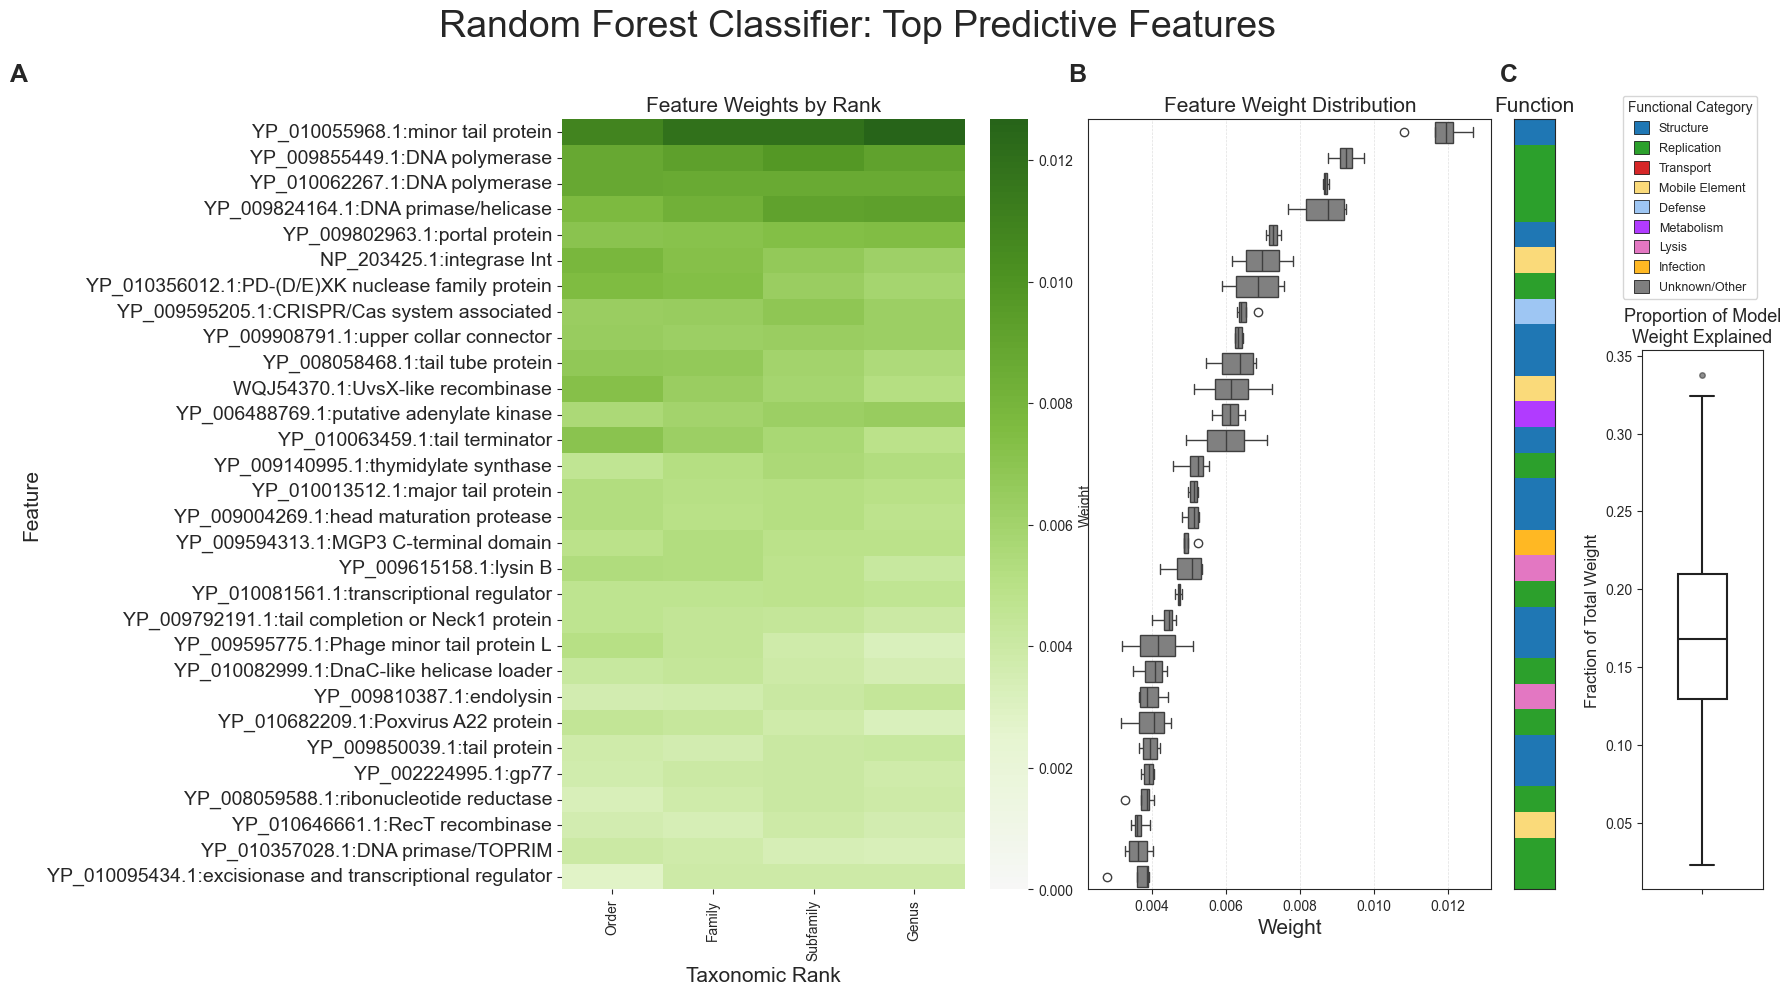

In [25]:
plot_siamcat_style_interpretation(imp_dfs, top_n=30)

In [16]:
# % of top 30 features that are structural or replicative
22/30

0.7333333333333333

The top 30 protein features account for ~15% of the total model importance, indicating that a small subset of features disproportionately drive taxonomic predictions. These proteins may represent core phylogenetic or functional signatures across viral orders.

In [26]:
df.loc[df.Order=='Mjï¿½lnirvirales','Order']='Mjolnirvirales'

In [27]:
top_feats = top_features

In [28]:
rename_map = {
    'YP_009595775.1:hypothetical protein FDH00_gp17': 'YP_009595775.1:Phage minor tail protein L',
    'YP_010682209.1:hypothetical protein PQE84_gp32': 'YP_010682209.1:Poxvirus A22 protein',
    'YP_009594313.1:hypothetical protein FDG92_gp24':'YP_009594313.1:MGP3 C-terminal domain',
    'WQJ54370.1:MAG: UvsX-like recombinase ':'WQJ54370.1:UvsX-like recombinase'
}

In [30]:
# Apply to df
df = df.rename(columns=rename_map)

C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


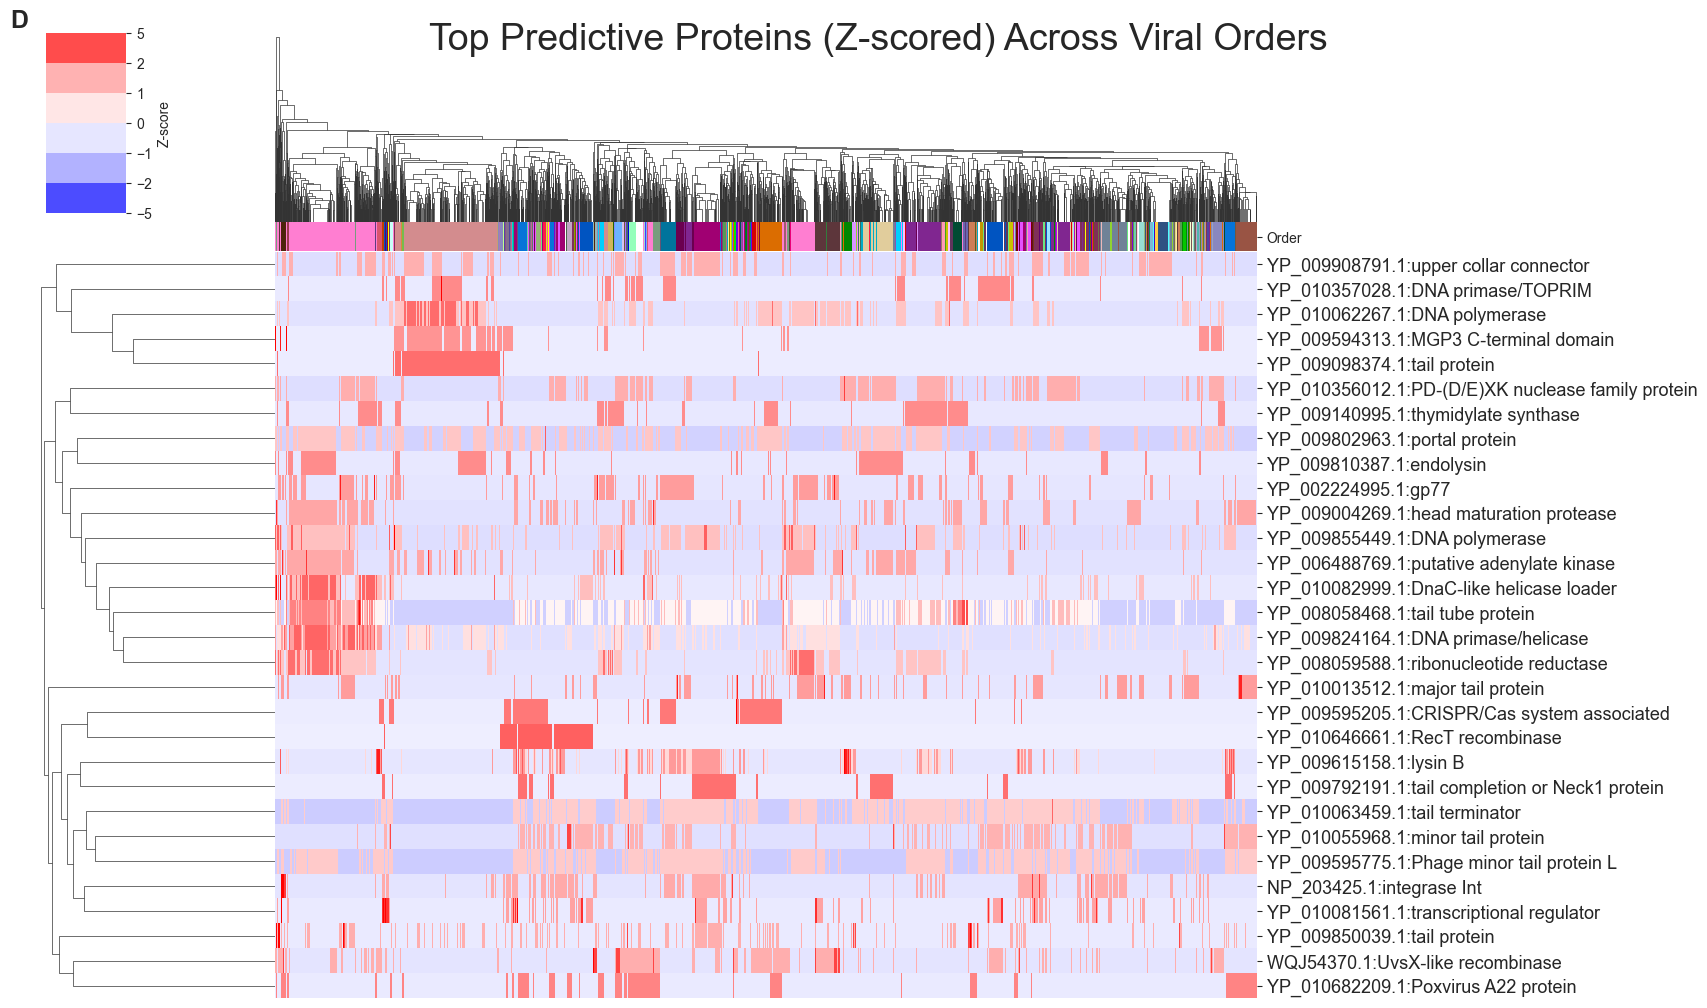

In [31]:
# Generate 154-color high-contrast palette
import colorcet as cc
import random
from scipy.stats import zscore

glasbey_colors = list(cc.glasbey)
while len(glasbey_colors) < 154:
    glasbey_colors += list(cc.glasbey)
final_palette = glasbey_colors[:154]
random.seed(42)
random.shuffle(final_palette)

# Compute z-score matrix
top_feats = [rename_map.get(f, f) for f in top_feats]
df[top_feats] = df[top_feats].apply(pd.to_numeric, errors='coerce')
z_df = df[top_feats].apply(zscore, axis=0)

# Map Orders to palette
z_df['Order'] = df['Order']
z_df = z_df.dropna(subset='Order').sort_values(by='Order')
orders = z_df['Order']
z_df = z_df.drop(columns='Order')
unique_orders = sorted(orders.unique())
order_colors = dict(zip(unique_orders, final_palette[:len(unique_orders)]))  # ← updated here
color_row = orders.map(order_colors)

from matplotlib.colors import ListedColormap, BoundaryNorm

boundaries = [-5, -2, -1, 0, 1, 2, 5]  # 7 bins => need 7 colors
colors = [
    "#AF3E3E",  # <= -2, deep red
    "#FAFFCA",  # -2 to -1, pale yellow
    '#E1EEBC',  # -1 to 0, pale green
    "#000000",  # 0 to 1, black
    '#F8F4E1',  # 1 to 2, white
    "#8DBCC7",  # 2 to 5, light blue
    "#5459AC"   # 5 to 10, darker blue
]

# Create colormap and normalization
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, ncolors=len(colors))

# Use in clustermap
g = sns.clustermap(
    z_df.T,
    col_colors=color_row,
    cmap='bwr',
    vmin=boundaries[0],
    vmax=boundaries[-1],
    figsize=(16, 10),
    xticklabels=False,
    yticklabels=True,
    cbar_kws={
        "label": "Z-score",
        "ticks": boundaries,
        "boundaries": boundaries
    }
)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=13)
g.ax_heatmap.text(
    -0.27, 1.3, "D", transform=g.ax_heatmap.transAxes,
    fontsize=18, fontweight='bold'
)

# ------------------- Reorder legend based on clustered column order -------------------
# # Get sample order from the clustered dendrogram
# col_order = g.dendrogram_col.reordered_ind
# ordered_samples = z_df.index[col_order]  # Get sample indices in clustered order
# ordered_orders = orders.loc[ordered_samples]  # Get their corresponding Orders

# # Get unique orders in appearance order (preserve order)
# from collections import OrderedDict
# ordered_unique_orders = list(OrderedDict.fromkeys(ordered_orders))

# # Remap legend handles in new order
# legend_handles = [Patch(color=order_colors[o], label=o) for o in ordered_unique_orders]

# # Plot legend
# g.fig.legend(
#     handles=legend_handles,
#     title="Order",
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.01),
#     bbox_transform=g.fig.transFigure,
#     ncol=8,
#     fontsize=9
# )

# # # Add legend
# legend_handles = [Patch(color=order_colors[o], label=o) for o in unique_orders]
# g.fig.legend(
#     handles=legend_handles,
#     title="Order",
#     loc='upper center',
#     bbox_to_anchor=(0.5,0),
#     bbox_transform=g.fig.transFigure,
#     ncol=8,
#     fontsize=9
# )
g.fig.suptitle("Top Predictive Proteins (Z-scored) Across Viral Orders", fontsize=27, y=0.99, x=0.54)
g.savefig("../data/plots/zscore_clustermap.png", bbox_inches='tight', dpi=300)
plt.show()

| Component              | Meaning                                                                                                                                  |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| **Rows (Y-axis)**      | Top features (structural protein cluster) selected based on model feature weight importance (top 30 most predictive features).                                                           |
| **Columns (X-axis)**   | Individual genomes from the dataset.                                                                                                    |
| **Color scale**        | Z-score of each feature’s abundance across genomes: - Negative (blue): underrepresented - Positive (red): enriched                      |
| **Top dendrogram**     | Hierarchical clustering of genomes (columns) based on feature similarity.                                                               |
| **Color bar (top)**    | Each column is colour-coded by the genome’s Order.                                                                                      |
| **Z-score bar (left)** | Indicates how standardized the feature values are.                                                                                      |
                                                                   |


In [32]:
from PIL import Image, ImageOps

def combine_plots_vertically(img1_path, img2_path, output_path, border=50, border_color="white"):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    # Make width consistent (resize if needed)
    width = max(img1.width, img2.width)
    img1 = img1.resize((width, int(img1.height * width / img1.width)))
    img2 = img2.resize((width, int(img2.height * width / img2.width)))

    # Create new image with combined height
    combined = Image.new("RGB", (width, img1.height + img2.height), color="white")
    combined.paste(img1, (0, 0))
    combined.paste(img2, (0, img1.height))

    # Add border around combined image
    bordered = ImageOps.expand(combined, border=border, fill=border_color)
    bordered.save(output_path)

combine_plots_vertically(
    "../data/plots/siamcat_features_interpretation.png",
    "../data/plots/zscore_clustermap.png",
    "../data/plots/features_figure.png",
    border=60,
    border_color="white"
)

print("woop")

woop


#  4. Novelty-aware post-prediction QC layer 👾🧬✨

## Compute Intra- and Inter- clade metrics

In [64]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm

def compute_clade_metrics(presence_matrix, metadata, rank='Family', similarity_metric='jaccard', distance_metric='euclidean'):
    """
    Compute intra- and inter-clade metrics (Euclidean & Jaccard) for a given taxonomic rank.

    Args:
        presence_matrix (pd.DataFrame): Genome x features presence/absence matrix.
        metadata (pd.DataFrame): DataFrame with index = genome IDs, and columns including the taxonomic ranks.
        rank (str): Taxonomic rank to compute metrics for. Must be a column in metadata.
        similarity_metric (str): Metric for % shared proteins (e.g. 'jaccard').
        distance_metric (str): Metric for distance (e.g. 'euclidean').

    Returns:
        intra_df (pd.DataFrame): Intra-clade similarity and distance.
        inter_df (pd.DataFrame): Inter-clade similarity and distance.
    """
    df = presence_matrix.copy()
    df.index = df.index.str.replace(r'\.\d+$', '', regex=True)
    metadata.index = metadata.index.str.replace(r'\.\d+$', '', regex=True)

    # Join labels
    df_labeled = df.join(metadata[[rank]])
    df_labeled = df_labeled.dropna(subset=[rank])

    clades = df_labeled[rank].unique()
    intra_rows = []
    inter_rows = []

    print(f"🔬 Computing intra-clade metrics for {len(clades)} {rank} clades...")
    for clade in tqdm(clades, desc=f"Intra-{rank}"):
        group = df_labeled[df_labeled[rank] == clade].drop(columns=[rank])
        if len(group) < 2:
            continue

        eucl = pairwise_distances(group.values, metric=distance_metric)
        jacc = pairwise_distances(group.values.astype(bool), metric=similarity_metric)

        tril_idx = np.triu_indices_from(eucl, k=1)
        eucl_vals = eucl[tril_idx]
        jacc_vals = jacc[tril_idx]
        shared_vals = 1 - jacc_vals  # Jaccard dissimilarity → shared %

        intra_rows.append({
            'rank': rank,
            'clade': clade,
            'n': len(group),
            'intra_avg_euclidean': np.mean(eucl_vals),
            'intra_median_euclidean': np.median(eucl_vals),
            'intra_std_euclidean': np.std(eucl_vals),
            'intra_min_euclidean': np.min(eucl_vals),
            'intra_max_euclidean': np.max(eucl_vals),

            'intra_avg_shared_proteins': np.mean(shared_vals),
            'intra_median_shared_proteins': np.median(shared_vals),
            'intra_std_shared_proteins': np.std(shared_vals),
            'intra_min_shared_proteins': np.min(shared_vals),
            'intra_max_shared_proteins': np.max(shared_vals)
        })

    print(f"\n🌍 Computing inter-clade metrics between {len(clades)} {rank} clades...")
    for clade_a, clade_b in tqdm(combinations(clades, 2), total=(len(clades)*(len(clades)-1))//2, desc=f"Inter-{rank}"):
        group_a = df_labeled[df_labeled[rank] == clade_a].drop(columns=[rank])
        group_b = df_labeled[df_labeled[rank] == clade_b].drop(columns=[rank])

        if group_a.empty or group_b.empty:
            continue

        eucl = pairwise_distances(group_a.values, group_b.values, metric=distance_metric)
        jacc = pairwise_distances(group_a.values.astype(bool), group_b.values.astype(bool), metric=similarity_metric)
        shared_vals = 1 - jacc

        inter_rows.append({
            'rank': rank,
            'clade_1': clade_a,
            'clade_2': clade_b,
            'n_clade_1': len(group_a),
            'n_clade_2': len(group_b),
            'inter_avg_euclidean': np.mean(eucl),
            'inter_median_euclidean': np.median(eucl),
            'inter_std_euclidean': np.std(eucl),
            'inter_avg_shared_proteins': np.mean(shared_vals),
            'inter_median_shared_proteins': np.median(shared_vals),
            'inter_std_shared_proteins': np.std(shared_vals)
        })

    intra_df = pd.DataFrame(intra_rows)
    inter_df = pd.DataFrame(inter_rows)
    return intra_df, inter_df

def filter_taxa_and_matrix(taxa_df, training_matrix_T, rank):
    """
    Filters metadata and training matrix to only include genomes with non-null values
    for the specified rank and that exist in the training matrix.

    Args:
        taxa_df (pd.DataFrame): Metadata with 'Leaves' column and taxonomic labels.
        training_matrix_T (pd.DataFrame): Transposed training matrix (genomes x features).
        rank (str): Taxonomic rank to filter on (e.g., 'Family', 'Genus').

    Returns:
        filtered_taxa_df (pd.DataFrame): Metadata filtered to genomes with valid labels and matching matrix.
        filtered_training_matrix (pd.DataFrame): Training matrix filtered to matching genomes.
    """
    taxa_df = taxa_df.copy()
    training_matrix_T = training_matrix_T.copy()

    # Drop NAs for the specified rank
    filtered_taxa_df = taxa_df[['Leaves', rank]].dropna()

    # Set index to Leaves so we can align with training_matrix_T
    filtered_taxa_df = filtered_taxa_df.set_index('Leaves')

    # Filter to matching genomes
    filtered_taxa_df = filtered_taxa_df[filtered_taxa_df.index.isin(training_matrix_T.index)]
    filtered_training_matrix = training_matrix_T.loc[filtered_taxa_df.index]
    print(f'Filtered df at {rank} level')

    return filtered_taxa_df, filtered_training_matrix

In [65]:
filtered_taxa_df_family, filtered_training_matrix_family = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Family')
filtered_taxa_df_order, filtered_training_matrix_order = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Order')
filtered_taxa_df_subfamily, filtered_training_matrix_subfamily = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Subfamily')
filtered_taxa_df_genus, filtered_training_matrix_genus = filter_taxa_and_matrix(taxa_df, training_matrix_T, rank='Genus')

intra_order, inter_order = compute_clade_metrics(filtered_training_matrix_order, filtered_taxa_df_order, rank="Order")
intra_family, inter_family = compute_clade_metrics(filtered_training_matrix_family, filtered_taxa_df_family, rank="Family")
intra_subfamily, inter_subfamily = compute_clade_metrics(filtered_training_matrix_subfamily, filtered_taxa_df_subfamily, rank="Subfamily")
intra_genus, inter_genus = compute_clade_metrics(filtered_training_matrix_genus, filtered_taxa_df_genus, rank="Genus")

intra_rank_relatedness = pd.concat([intra_order, intra_family, intra_subfamily, intra_genus])
inter_rank_relatedness = pd.concat([inter_order, inter_family, inter_subfamily, inter_genus])

Filtered df at Family level
Filtered df at Order level
Filtered df at Subfamily level
Filtered df at Genus level
🔬 Computing intra-clade metrics for 159 Order clades...


Intra-Order: 100%|███████████████████████████████████████████████████████████████████| 159/159 [00:22<00:00,  7.20it/s]



🌍 Computing inter-clade metrics between 159 Order clades...


Inter-Order: 100%|███████████████████████████████████████████████████████████████| 12561/12561 [29:32<00:00,  7.09it/s]


In [66]:
intra_family, inter_family = compute_clade_metrics(filtered_training_matrix_family, filtered_taxa_df_family, rank="Family")
intra_subfamily, inter_subfamily = compute_clade_metrics(filtered_training_matrix_subfamily, filtered_taxa_df_subfamily, rank="Subfamily")
intra_genus, inter_genus = compute_clade_metrics(filtered_training_matrix_genus, filtered_taxa_df_genus, rank="Genus")

intra_rank_relatedness = pd.concat([intra_order, intra_family, intra_subfamily, intra_genus])
inter_rank_relatedness = pd.concat([inter_order, inter_family, inter_subfamily, inter_genus])

🔬 Computing intra-clade metrics for 267 Family clades...


Intra-Family: 100%|██████████████████████████████████████████████████████████████████| 267/267 [00:14<00:00, 18.85it/s]



🌍 Computing inter-clade metrics between 267 Family clades...


Inter-Family: 100%|██████████████████████████████████████████████████████████████| 35511/35511 [47:27<00:00, 12.47it/s]


🔬 Computing intra-clade metrics for 502 Subfamily clades...


Intra-Subfamily: 100%|███████████████████████████████████████████████████████████████| 502/502 [00:13<00:00, 38.22it/s]



🌍 Computing inter-clade metrics between 502 Subfamily clades...


Inter-Subfamily: 100%|███████████████████████████████████████████████████████| 125751/125751 [1:35:32<00:00, 21.94it/s]


🔬 Computing intra-clade metrics for 1189 Genus clades...


Intra-Genus: 100%|█████████████████████████████████████████████████████████████████| 1189/1189 [00:14<00:00, 82.40it/s]



🌍 Computing inter-clade metrics between 1189 Genus clades...


Inter-Genus: 100%|███████████████████████████████████████████████████████████| 706266/706266 [5:07:03<00:00, 38.34it/s]


In [68]:
inter_rank_relatedness.to_csv('../data/inter_rank_relatedness.csv',index=False)

In [69]:
intra_rank_relatedness.to_csv('../data/intra_rank_relatedness.csv',index=False)

In [11]:
inter_rank_relatedness = pd.read_csv('../data/inter_rank_relatedness.csv')
intra_rank_relatedness = pd.read_csv('../data/intra_rank_relatedness.csv')

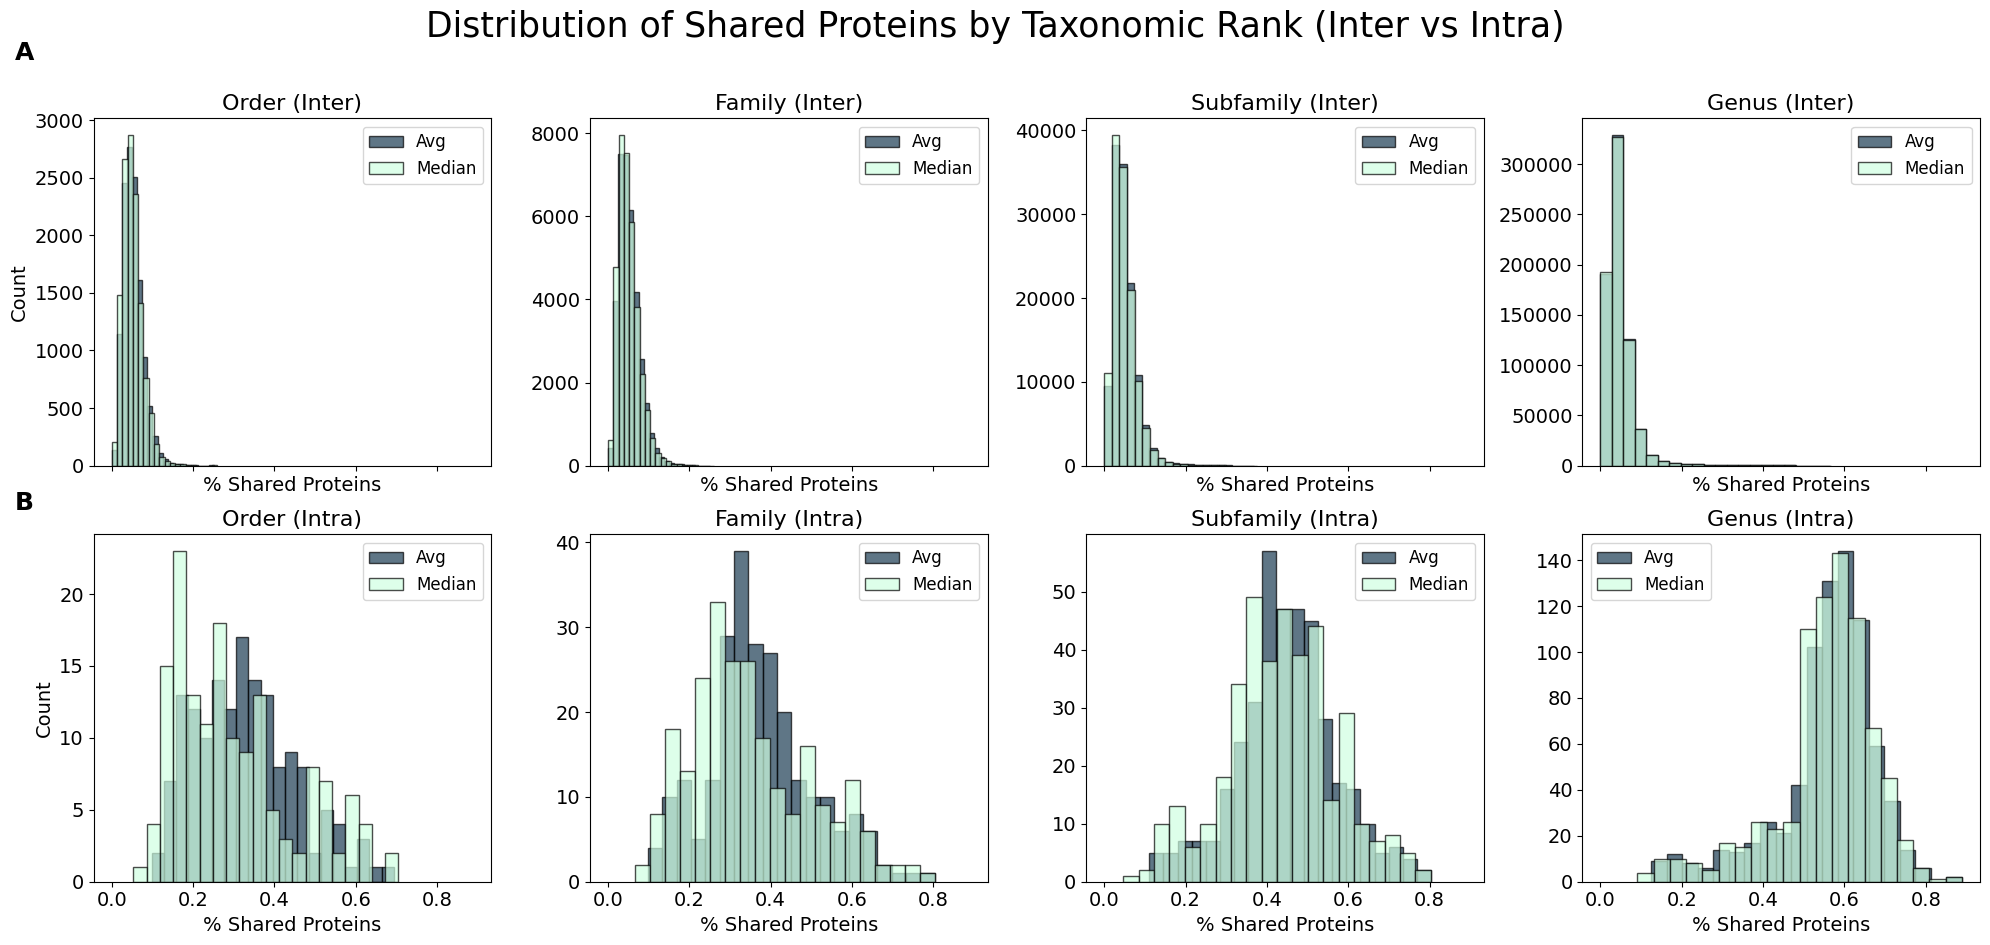

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=False)
fig.suptitle("Distribution of Shared Proteins by Taxonomic Rank (Inter vs Intra)", fontsize=25, y=0.97)

avg_color = '#1B3C53'      
median_color = '#CFFFE2'   

ranks = ['Order', 'Family', 'Subfamily', 'Genus']
for j, df in enumerate([inter_rank_relatedness, intra_rank_relatedness]):
    context = "Inter" if j == 0 else "Intra"
    for i, rank in enumerate(ranks):
        subset = df[df['rank'] == rank]
        ax = axs[j, i]
        
        # Plot histograms
        if context == "Inter":
            ax.hist(subset['inter_avg_shared_proteins'], bins=20, alpha=0.7, label='Avg',
                    edgecolor='black', color=avg_color)
            ax.hist(subset['inter_median_shared_proteins'], bins=20, alpha=0.7, label='Median',
                    edgecolor='black', color=median_color)
        else:
            ax.hist(subset['intra_avg_shared_proteins'], bins=20, alpha=0.7, label='Avg',
                    edgecolor='black', color=avg_color)
            ax.hist(subset['intra_median_shared_proteins'], bins=20, alpha=0.7, label='Median',
                    edgecolor='black', color=median_color)

        # Set titles and labels with larger fonts
        ax.set_title(f"{rank} ({context})", fontsize=16)
        ax.set_xlabel("% Shared Proteins", fontsize=14)
        if i == 0:
            ax.set_ylabel("Count", fontsize=14)

        # Tick font sizes
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        # Legend font size
        ax.legend(fontsize=12)

# Panel labels
fig.text(0.01, 0.92, "A", fontsize=18, fontweight='bold')
fig.text(0.01, 0.47, "B", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../data/plots/inter_vs_intra_shared_protein_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
intra_rank_relatedness.groupby('rank')['intra_avg_shared_proteins'].mean()

rank
Family       0.374887
Genus        0.556628
Order        0.328001
Subfamily    0.449797
Name: intra_avg_shared_proteins, dtype: float64

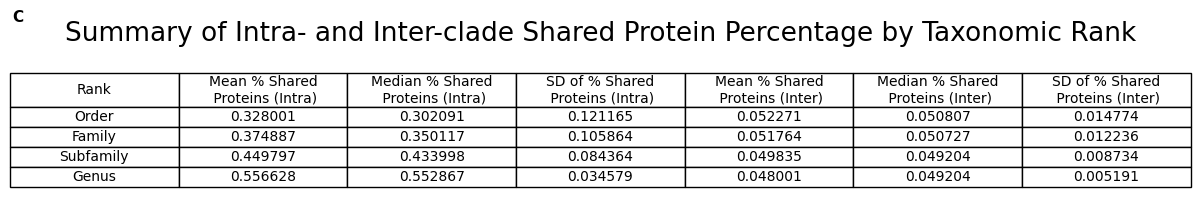

In [24]:
data = {
    "Rank": ["Order", "Family", "Subfamily", "Genus"],
    "Mean % Shared\n Proteins (Intra)": [0.328001, 0.374887, 0.449797, 0.556628],
    "Median % Shared\n Proteins (Intra)": [0.302091, 0.350117, 0.433998, 0.552867],
    "SD of % Shared\n Proteins (Intra)": [0.121165, 0.105864, 0.084364, 0.034579],
    "Mean % Shared\n Proteins (Inter)": [0.052271, 0.051764, 0.049835, 0.048001],
    "Median % Shared\n Proteins (Inter)": [0.050807, 0.050727, 0.049204, 0.049204],
    "SD of % Shared\n Proteins (Inter)": [0.014774, 0.012236, 0.008734, 0.005191]
}

df = pd.DataFrame(data)

# Plot table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Increase height of header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_height(0.28)

# Title
plt.title("Summary of Intra- and Inter-clade Shared Protein Percentage by Taxonomic Rank",
          fontsize=19, pad=20)
fig.text(0.01, 0.92, "C", fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig("../data/plots/supplementary_table_intra_inter_%_shared.png", dpi=300, bbox_inches='tight')
plt.show()

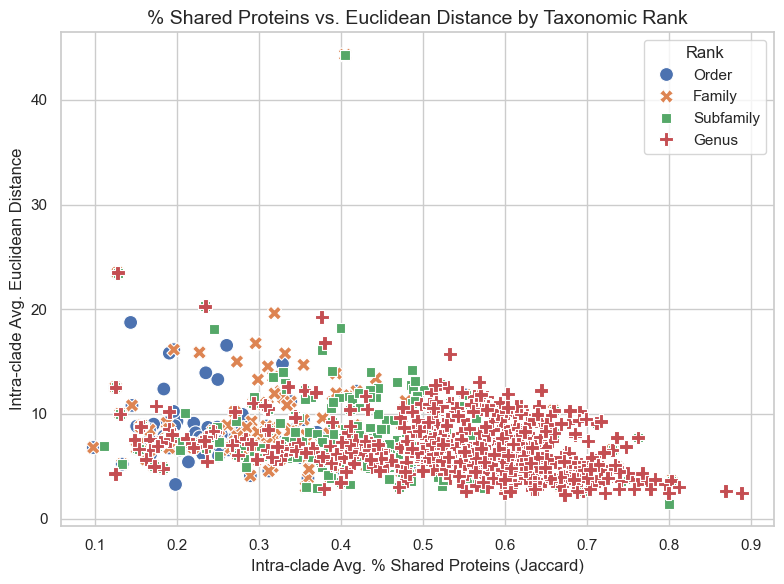

In [70]:
# Set seaborn style
sns.set(style="whitegrid")

# Create seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=intra_rank_relatedness,
    x='intra_avg_shared_proteins',
    y='intra_avg_euclidean',
    hue='rank',
    style='rank',
    s=100,
    palette='deep'
)

plt.title('% Shared Proteins vs. Euclidean Distance by Taxonomic Rank', fontsize=14)
plt.xlabel('Intra-clade Avg. % Shared Proteins (Jaccard)', fontsize=12)
plt.ylabel('Intra-clade Avg. Euclidean Distance', fontsize=12)
plt.legend(title='Rank')
plt.tight_layout()

# Save the figure
output_path = "../data/plots/intra_similarity_by_rank_plot_30_06_25.png"
plt.savefig(output_path, dpi=300)
plt.show()

plt.close()

# 5. Test classifier on held-out ictv sequences..

In [165]:
# Import foldseek search hits of test 10k novel phage sequences
search = pd.read_csv('../data/foldseek_easy_cluster/phagepleats_test_search/search_result.tsv', sep='\t', header=None)
search.columns = ['query','target','fident','alnlen','mismatch','gapopen','qstart','qend','tstart','tend','evalue','bits']

In [166]:
search.shape

(283229, 12)

In [167]:
genome_prot_map = pd.read_csv('../data/foldseek_easy_cluster/phagepleats_test_search/genome_protein_map.csv')

In [168]:
# Merge to add 'query_genome' from genome_prot_map based on the 'query' column
search = search.merge(
    genome_prot_map.rename(columns={'protein': 'query', 'genome': 'query_genome'}),
    on='query',
    how='left'
)

In [169]:
search['target'] = search['target'].str.replace('.pdb','')

# Extract index from presence_absence
index = training_matrix['cluster_ID_function']

unique_genomes = sorted(search['query_genome'].astype(str).unique())

# Create an empty DataFrame with the specified index and columns
input_df = pd.DataFrame(index=index, columns=unique_genomes)

# Extract unique clusters and genomes
cluster_reps = search['target'].unique()
genomes = search['query_genome'].unique()

# Loop through clusters and update presence DataFrame
for genome in tqdm(genomes, desc="Checking genome presence"):
    genome_clusters = search[search['query_genome'] == genome]['target']
    
    if not genome_clusters.empty:
        # Create a mask for the index
        mask = input_df.index.str.contains('|'.join(genome_clusters), na=False)
        
        # Update the presence DataFrame
        input_df.loc[mask, genome] = 1

Checking genome presence: 100%|████████████████████████████████████████████████████| 1718/1718 [02:09<00:00, 13.25it/s]


In [170]:
# Find unique genome values in genome_prot_map that are NOT in input_df.columns
missing_genomes = genome_prot_map['genome'][~genome_prot_map['genome'].isin(input_df.columns)].unique()
print(missing_genomes)

[]


In [171]:
input_df = input_df.fillna(0)
input_df_T = input_df.T
input_df_T = input_df_T[training_matrix_T.columns]
input_df_T = input_df_T[input_df_T.index != 'nan']

In [173]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

def load_models_from_folder(folder_path):
    models = {}
    for fname in os.listdir(folder_path):
        if fname.endswith(".pkl"):
            taxon = fname.replace(".pkl", "")
            full_path = os.path.join(folder_path, fname)
            with open(full_path, "rb") as f:
                models[taxon] = pickle.load(f)
    return models

def predict_from_models(X, models, rank):
    prob_list = []  # To store the probability columns for concatenation later
    pred_labels = []
    pred_scores = []

    for taxon, model in tqdm(models.items(), desc=f"Predicting for {rank}"):
        probs = model.predict_proba(X)[:, 1]  # probability of class 1
        prob_list.append(probs)

    prob_matrix = pd.DataFrame(np.column_stack(prob_list), index=X.index, columns=models.keys())

    # Get the predicted labels (highest probability for each row)
    pred_labels = prob_matrix.idxmax(axis=1)
    pred_scores = prob_matrix.max(axis=1)

    # Combine predictions into a DataFrame
    df_out = pd.DataFrame({
        f"{rank}": pred_labels,
        f"{rank}_prob": pred_scores
    }, index=X.index)

    return df_out, prob_matrix

def predict_all_ranks(X, ranks=["Order", "Family", "Subfamily", "Genus"], model_base="models/production"):
    all_preds = []
    os.makedirs("rank_probabilities", exist_ok=True)

    for rank in ranks:
        print(f"\n🔮✨ Predicting for rank: {rank}")
        model_path = os.path.join(model_base, rank)
        if not os.path.exists(model_path):
            print(f"❌ No model directory for {rank}: {model_path}")
            continue

        models = load_models_from_folder(model_path)
        if not models:
            print(f"⚠️ No models found in {model_path}")
            continue

        df_rank, df_proba = predict_from_models(X, models, rank)
        df_rank.index = X.index
        all_preds.append(df_rank)

        # Save the full probability matrix for this rank
        df_proba.to_csv(f"rank_probabilities/{rank}_proba.csv")

    # Concatenate all ranks into one final DataFrame
    final_df = pd.concat(all_preds, axis=1)
    final_df.index.name = "Genome"
    #final_df.reset_index().to_csv("../data/final_predictions_ictv_vmr40.csv", index=False)

    print("\n✅ Final predictions saved to 'final_predictions.csv'")
    print("📂 Full probability matrices saved to 'rank_probabilities/'")

    return final_df

In [174]:
ictv_vmr39_predictions = predict_all_ranks(input_df_T, model_base='../data/models/production/')


🔮✨ Predicting for rank: Order


Predicting for Order: 100%|██████████████████████████████████████████████████████████| 159/159 [00:22<00:00,  6.92it/s]



🔮✨ Predicting for rank: Family


Predicting for Family: 100%|█████████████████████████████████████████████████████████| 267/267 [00:38<00:00,  6.94it/s]



🔮✨ Predicting for rank: Subfamily


Predicting for Subfamily: 100%|██████████████████████████████████████████████████████| 502/502 [01:13<00:00,  6.83it/s]



🔮✨ Predicting for rank: Genus


Predicting for Genus: 100%|████████████████████████████████████████████████████████| 1189/1189 [02:53<00:00,  6.85it/s]



✅ Final predictions saved to 'final_predictions.csv'
📂 Full probability matrices saved to 'rank_probabilities/'


In [175]:
# Test models on new data
ictv_vmr40 = pd.read_excel('../data/VMR_MSL40.v1.20250307.xlsx',sheet_name=1)
caudo = ictv_vmr40[ictv_vmr40.Class=='Caudoviricetes']

ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')

test_phages = caudo[~caudo['Virus GENBANK accession'].isin(ictv_metadata['Virus GENBANK accession']) & 
                  ~caudo['Virus GENBANK accession'].isin(ictv_metadata['genome_accn'])]

C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\Users\crtuser\anaconda3\envs\folding\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [176]:
ictv_vmr39_predictions = ictv_vmr39_predictions.rename(columns={"Order":'Order_Pred',
                                       "Family":'Family_Pred',
                                       "Subfamily":'Subfamily_Pred',
                                       "Genus":'Genus_Pred'})

In [177]:
ictv_vmr39_predictions = ictv_vmr39_predictions.merge(test_phages, left_on=ictv_vmr39_predictions.index, right_on='Virus GENBANK accession')

In [178]:
df = ictv_vmr39_predictions

In [179]:
df[0:1]

,Order_Pred,Order_prob,Family_Pred,Family_prob,Subfamily_Pred,Subfamily_prob,Genus_Pred,Genus_prob,Isolate ID,Species Sort,...,ICTV_ID,Exemplar or additional isolate,Virus name(s),Virus name abbreviation(s),Virus isolate designation,Virus GENBANK accession,Genome coverage,Genome,Host source,Accessions Link
0,Rountreevirales,0.08,Rountreeviridae_1,0.08,Rakietenvirinae_2,0.05,Epaquintavirus,0.12,VMR1001916,2612,...,ICTV20150189,E,Bacillus phage SPG24,NaN,NaN,AB930182,Complete genome,dsDNA,bacteria,NCBI Nucleotide


In [180]:
order_accuracy = df[df.Order.notna()]
family_accuracy = df[df.Family.notna()]
family_accuracy = family_accuracy[family_accuracy.Family.isin(ictv_metadata.Family.to_list())]
subfamily_accuracy = df[df.Subfamily.notna()]
subfamily_accuracy = subfamily_accuracy[subfamily_accuracy.Subfamily.isin(ictv_metadata.Subfamily.to_list())]
genus_accuracy = df[df.Genus.notna()]
genus_accuracy = genus_accuracy[genus_accuracy.Genus.isin(ictv_metadata.Genus.to_list())]


order_predicted_correct = order_accuracy[order_accuracy.Order_Pred.str.split('_').str[0] == order_accuracy.Order]
family_predicted_correct = family_accuracy[family_accuracy.Family_Pred.str.split('_').str[0] == family_accuracy.Family]
subfamily_predicted_correct = subfamily_accuracy[subfamily_accuracy.Subfamily_Pred.str.split('_').str[0] == subfamily_accuracy.Subfamily]
genus_predicted_correct = genus_accuracy[genus_accuracy.Genus_Pred.str.split('_').str[0]  == genus_accuracy.Genus]

In [103]:
order_accuracy.shape

(603, 36)

In [104]:
order_predicted_correct.shape

(602, 36)

In [105]:
# which one was incorrect??
602/603

0.9983416252072969

In [106]:
family_accuracy.shape

(854, 36)

In [107]:
family_predicted_correct.shape

(785, 36)

In [108]:
785/854

0.9192037470725996

In [109]:
subfamily_accuracy.shape

(1019, 36)

In [110]:
subfamily_predicted_correct.shape

(941, 36)

In [111]:
941/1019

0.9234543670264965

In [112]:
genus_accuracy.shape

(1141, 36)

In [113]:
genus_predicted_correct.shape

(998, 36)

In [114]:
998/1141

0.8746713409290097

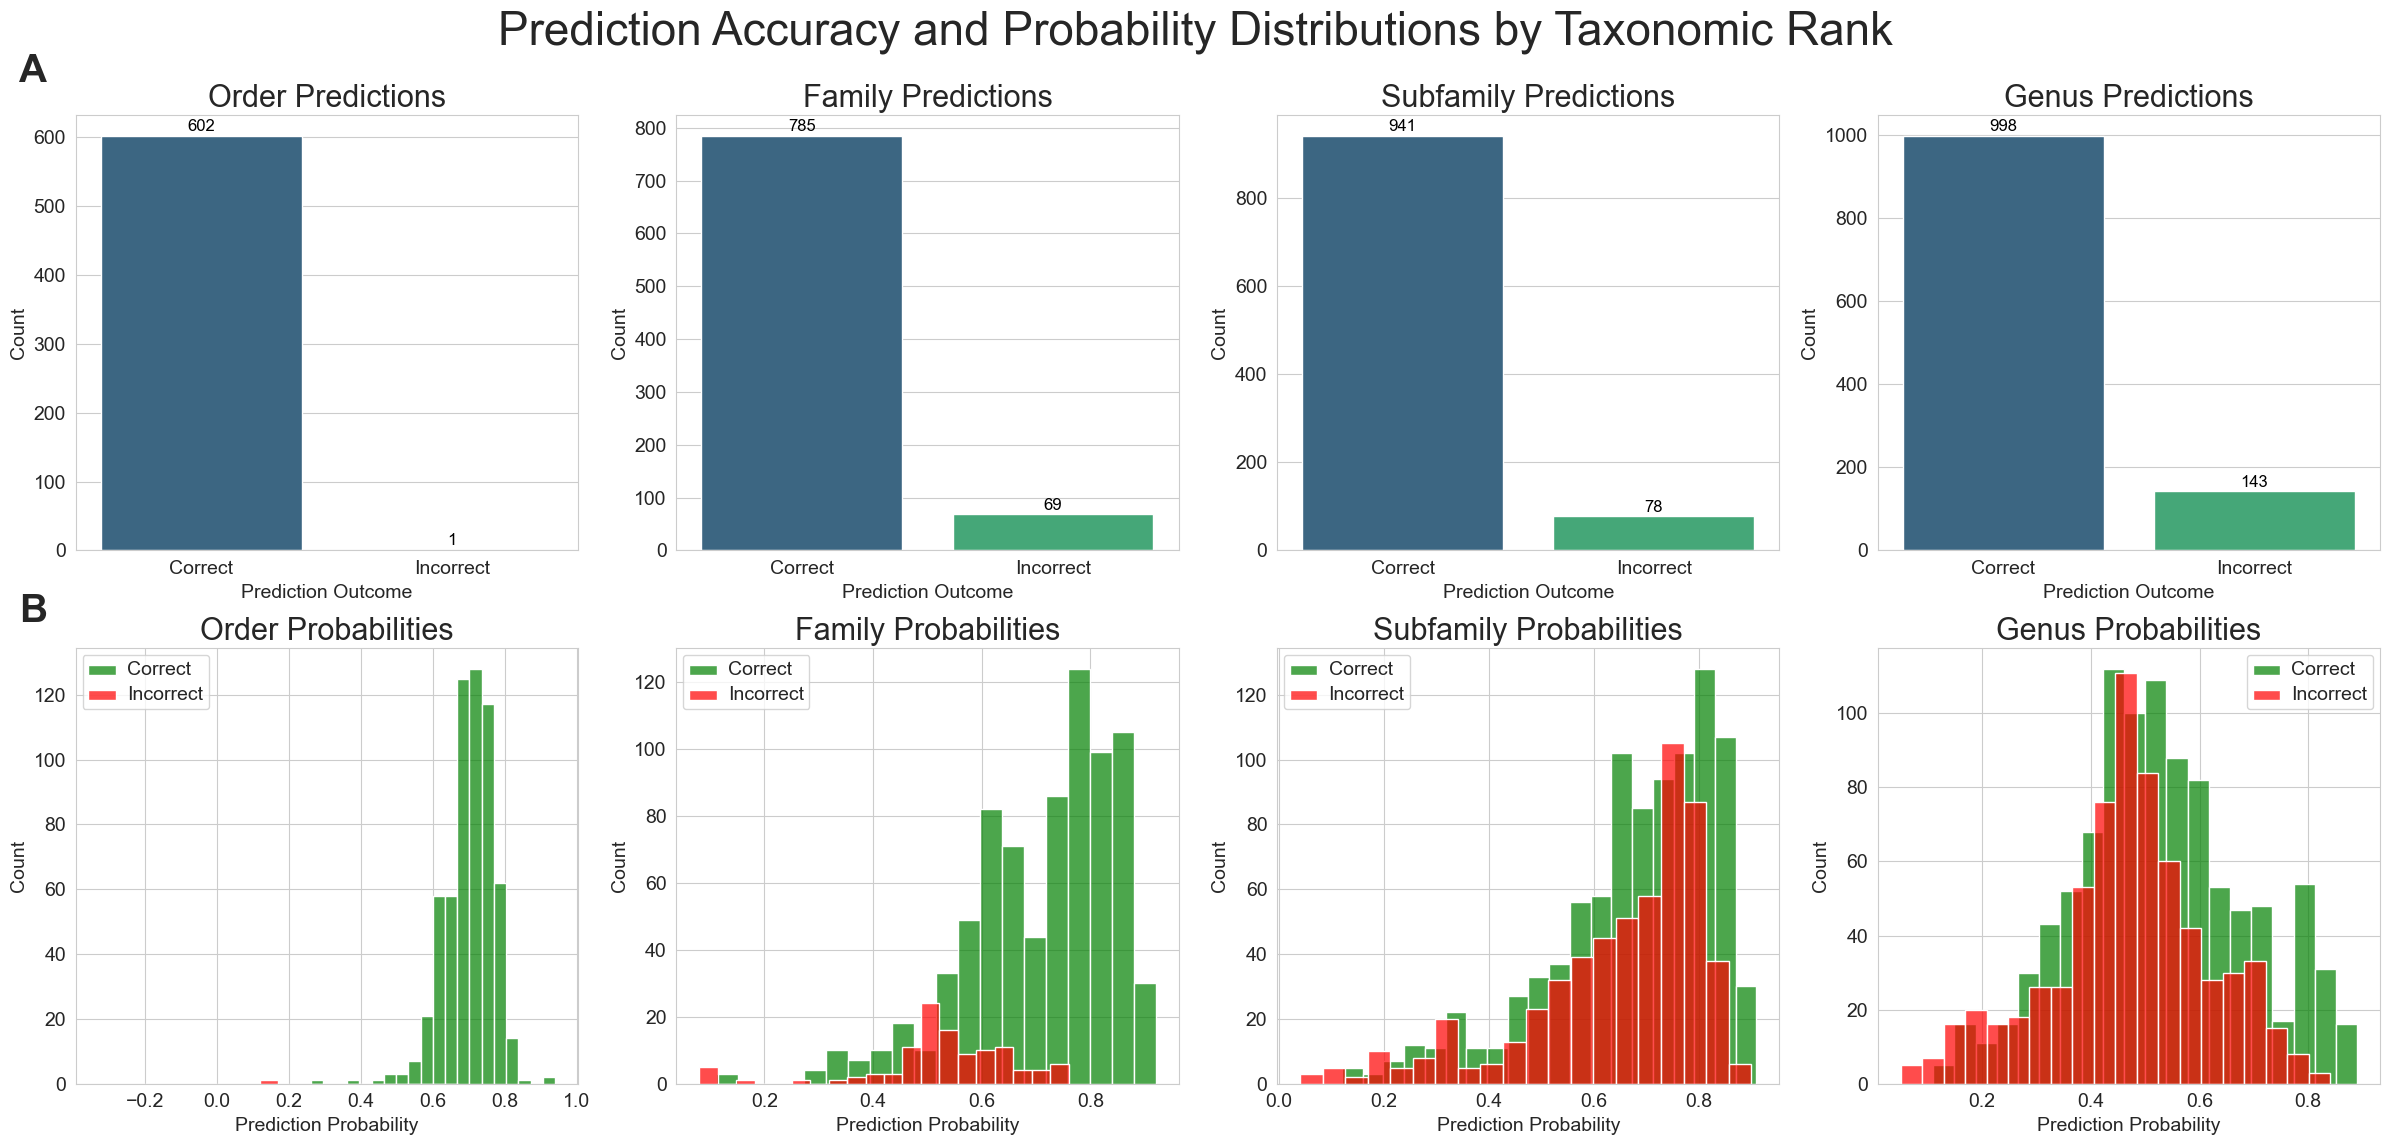

In [187]:
# Define correct and incorrect counts
correct_order_count = len(order_predicted_correct)
incorrect_order_count = len(order_accuracy) - correct_order_count

correct_family_count = len(family_predicted_correct)
incorrect_family_count = len(family_accuracy) - correct_family_count

correct_subfamily_count = len(subfamily_predicted_correct)
incorrect_subfamily_count = len(subfamily_accuracy) - correct_subfamily_count

correct_genus_count = len(genus_predicted_correct)
incorrect_genus_count = len(genus_accuracy) - correct_genus_count

incorrect_order_predictions = order_accuracy[order_accuracy['Order_Pred'] != order_accuracy['Order']]['Order_prob']
incorrect_family_predictions = family_accuracy[family_accuracy['Family_Pred'] != family_accuracy['Family']]['Family_prob']
incorrect_subfamily_predictions = subfamily_accuracy[subfamily_accuracy['Subfamily_Pred'] != subfamily_accuracy['Subfamily']]['Subfamily_prob']
incorrect_genus_predictions = genus_accuracy[genus_accuracy['Genus_Pred'] != genus_accuracy['Genus']]['Genus_prob']

order_correct_probs = order_predicted_correct['Order_prob']
family_correct_probs = family_predicted_correct['Family_prob']
subfamily_correct_probs = subfamily_predicted_correct['Subfamily_prob']
genus_correct_probs = genus_predicted_correct['Genus_prob']

sns.set_style("whitegrid")

levels = ['Order', 'Family', 'Subfamily', 'Genus']
correct_dfs = [order_predicted_correct, family_predicted_correct, subfamily_predicted_correct, genus_predicted_correct]
accuracy_dfs = [order_accuracy, family_accuracy, subfamily_accuracy, genus_accuracy]

fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for i, (level, correct_df, acc_df) in enumerate(zip(levels, correct_dfs, accuracy_dfs)):
    # Barplot Data
    correct_count = len(correct_df)
    incorrect_count = len(acc_df) - correct_count
    bar_df = pd.DataFrame({'Status': ['Correct', 'Incorrect'], 'Count': [correct_count, incorrect_count]})

    # Accuracy Barplot (Top Row)
    sns.barplot(data=bar_df, x='Status', y='Count', hue='Status',
                ax=axes[0, i], palette='viridis', legend=False)
    axes[0, i].set_title(f'{level} Predictions', fontsize=22)
    axes[0, i].set_xlabel('Prediction Outcome', fontsize=14)
    axes[0, i].set_ylabel('Count', fontsize=14)
    axes[0, i].tick_params(axis='both', labelsize=14)
    for p in axes[0, i].patches:
        axes[0, i].annotate(f'{int(p.get_height())}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=12, color='black',
                            xytext=(0, 1), textcoords='offset points')

    correct_probs = correct_df[f'{level}_prob']
    incorrect_probs = acc_df[acc_df[f'{level}_Pred'] != acc_df[level]][f'{level}_prob']

    sns.histplot(correct_probs, ax=axes[1, i], color='green', label='Correct', bins=20, alpha=0.7)
    sns.histplot(incorrect_probs, ax=axes[1, i], color='red', label='Incorrect', bins=20, alpha=0.7)
    axes[1, i].set_title(f'{level} Probabilities', fontsize=22)
    axes[1, i].set_xlabel('Prediction Probability', fontsize=14)
    axes[1, i].set_ylabel('Count', fontsize=14)
    axes[1, i].tick_params(axis='both', labelsize=14)
    legend = axes[1, i].legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(14)

fig.text(0.01, 0.89, 'A', fontsize=28, fontweight='bold')  
fig.text(0.01, 0.44, 'B', fontsize=28, fontweight='bold')  

fig.suptitle('Prediction Accuracy and Probability Distributions by Taxonomic Rank', fontsize=33, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("../data/plots/ictv_vmr40_taxa_predictions_accuracy_and_probabilities.png", dpi=300, bbox_inches='tight')

# 6. Hierarchical classification

Implement Hierarchical Prediction..

* Train separate models for each level of classification (Order, Family, Subfamily, Genus).
* For each sample, make the order prediction first.
* Filter classifiers at the next level (Family) to use only those models that correspond to the predicted order.
* Repeat the process for the Subfamily and Genus levels, filtering down to the relevant classifiers.

# Create taxa mappings

In [6]:
orders_hierarchy = {}

for _, row in taxa_df.iterrows():
    order = row['Order']
    
    # Only assign to family, subfamily, and genus if they are not NaN
    family = row.get('Family') if pd.notna(row.get('Family')) else None
    subfamily = row.get('Subfamily') if pd.notna(row.get('Subfamily')) else None
    genus = row.get('Genus') if pd.notna(row.get('Genus')) else None

    # Skip row if any key is None (i.e., missing)
    if pd.isna(family) or pd.isna(subfamily) or pd.isna(genus):
        continue

    # Initialize the order key if not already present
    if order not in orders_hierarchy:
        orders_hierarchy[order] = {'Family': set()}

    # Add the family to the families set
    orders_hierarchy[order]['Family'].add(family)

    # Initialize family if not present
    if family not in orders_hierarchy[order]:
        orders_hierarchy[order][family] = {'Subfamily': set()}

    # Add the subfamily to the subfamilies set
    orders_hierarchy[order][family]['Subfamily'].add(subfamily)

    # Initialize subfamily if not present
    if subfamily not in orders_hierarchy[order][family]:
        orders_hierarchy[order][family][subfamily] = {'Genus': set()}

    # Add the genus to the genera set
    orders_hierarchy[order][family][subfamily]['Genus'].add(genus)

# Ensure the orders exist before assigning a family
for order in ['Verdandivirales', 'Dunevirales', 'Graavivirales', 'Kirjokansivirales']:
    if order not in orders_hierarchy:
        orders_hierarchy[order] = {}  # Initialize the order key
    
    orders_hierarchy[order]['Family'] = {'Unknown'}

# Get all families under a specific order
# orders_hierarchy[order]['families']

# Get all subfamilies under a specific family
# orders_hierarchy[order][family]['subfamilies']

# Get all genera under a specific subfamily
# orders_hierarchy[order][family][subfamily]['genera']

In [7]:
orders_hierarchy.keys()

dict_keys(['Casjensvirales', 'Strabovirales', 'Crassvirales', 'Drexlervirales', 'Aliceevansvirales', 'Peduovirales', 'Rountreevirales', 'Orlajensenvirales', 'Verdandivirales', 'Dunevirales', 'Graavivirales', 'Kirjokansivirales'])

In [123]:
import os
import pandas as pd
import logging
import pickle
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)

def load_model(model_path):
    """Load a machine learning model from a .pkl file."""
    try:
        with open(model_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        logging.error(f"Failed to load model {model_path}: {e}")
        return None

def predict_level(df, models_dict, level_name):
    """Predict a hierarchical level and return predictions with probabilities."""
    predictions = {}
    
    for label, model in tqdm(models_dict.items(), desc=f"Predicting {level_name}"):
        probs = model.predict_proba(df)[:, 1]  # Assume binary classification
        predictions[label] = probs
    
    df_predictions = pd.DataFrame(predictions, index=df.index)
    df_predictions[f"{level_name}_Prob"] = df_predictions.max(axis=1)
    df_predictions[f"{level_name}_Pred"] = df_predictions.idxmax(axis=1)
    
    return df_predictions[[f"{level_name}_Pred", f"{level_name}_Prob"]]

def get_models(model_dir, level):
    """Load models for a specific hierarchical level."""
    model_files = [f for f in os.listdir(os.path.join(model_dir, level)) if f.endswith('.pkl')]
    return {f.replace('.pkl', ''): load_model(os.path.join(model_dir, level, f)) for f in tqdm(model_files, desc=f"Loading {level} models")}

def process_level(df, parent_predictions, hierarchy, level_name, models_dir, parent_level):
    """Process hierarchical classification for a given level."""
    level_predictions = []

    grouped = list(parent_predictions.groupby(f'{parent_level}_Pred'))  # Convert to list to get length
    for parent, group in grouped:
        if level_name == 'Order' or level_name == 'Family':
            children = hierarchy.get(parent, {}).get(level_name, [])
            print(children)
        elif level_name == 'Subfamily':
            order = group['Order_Pred']
            family = group['Family_Pred']
            children = []
            for o, f in zip(order, family):
                children.extend(hierarchy.get(o, {}).get(f, {}).get(level_name, []))  
            children = list(set(children))  # Remove duplicates
        elif level_name == 'Genus':
            children = []
            order = group['Order_Pred']
            family = group['Family_Pred']
            subfamily = group['Subfamily_Pred']
            for o, f, s in zip(order, family, subfamily):
                children = hierarchy.get(o, {}).get(f, {}).get(s, {}).get(level_name, [])
        
        # If no children found, assign 'Unknown'
        if not children or children == {'Unknown'}:
            df_unknown = pd.DataFrame({
                f'{level_name}_Pred': ['Unknown'] * len(group),
                f'{level_name}_Prob': [0.0] * len(group)  # Set probability to 0
            }, index=group.index)
            level_predictions.append(df_unknown)
            continue  # Skip model loading for unknowns
        
        # Load models for children
        level_models = {child: load_model(os.path.join(models_dir, level_name, f"{child}.pkl")) 
                        for child in children if os.path.isfile(os.path.join(models_dir, level_name, f"{child}.pkl"))}
        
        df_level = predict_level(df.loc[group.index], level_models, level_name)
        df_level[f'{parent_level}_Pred'] = parent  # Maintain hierarchy
        level_predictions.append(df_level)
    
    return pd.concat(level_predictions) if level_predictions else pd.DataFrame()

def merge_and_rename(df1, df2, merge_cols, new_col_name_dict=None):
    """Merge two DataFrames on the index and rename columns if needed."""
    # Merge the two DataFrames
    merged_df = df1.merge(df2, left_index=True, right_index=True)

    # Rename columns as needed
    if new_col_name_dict:
        merged_df = merged_df.rename(columns=new_col_name_dict)

    # Drop duplicate columns (if any)
    for col in merge_cols:
        if f"{col}_y" in merged_df.columns:
            merged_df = merged_df.drop(f"{col}_y", axis=1)
        if f"{col}_x" in merged_df.columns:
            merged_df = merged_df.rename(columns={f"{col}_x": col})

    return merged_df

def hierarchical_classification(df_input, models_dir, hierarchy):
    """Run the hierarchical classification pipeline."""
    
    # Predict Order level
    df_orders = predict_level(df_input, get_models(models_dir, "Order"), "Order")
    
    # Predict Family level
    df_families = process_level(df_input, df_orders, hierarchy, "Family", models_dir, "Order")
    
    # Merge Order and Family predictions
    df_orders_families_pred = merge_and_rename(
        df_orders[['Order_Pred', 'Order_Prob']], 
        df_families, 
        merge_cols=['Order_Pred'],
        new_col_name_dict={'Family_Pred_x': 'Family_Pred'}
    )

    print(df_orders_families_pred)
    print(df_orders_families_pred.columns)
    # Predict Subfamily level
    df_subfamilies = process_level(df_input, df_orders_families_pred, hierarchy, "Subfamily", models_dir, "Family")
    
    # Merge Order, Family, and Subfamily predictions
    df_orders_families_subfamilies_pred = merge_and_rename(
        df_orders_families_pred[['Order_Pred', 'Order_Prob', 'Family_Pred', 'Family_Prob']],
        df_subfamilies,
        merge_cols=['Order_Pred', 'Family_Pred'],
        new_col_name_dict={'Subfamily_Pred_x': 'Subfamily_Pred'}
    )
    
    # Predict Genus level
    df_genus = process_level(df_input, df_orders_families_subfamilies_pred, hierarchy, "Genus", models_dir, "Subfamily")
    df_genus = df_genus[['Genus_Pred', 'Genus_Prob']]
    
    # Final merge with Genus predictions
    df_final = df_orders_families_subfamilies_pred.merge(df_genus, left_index=True, right_index=True)
    
    print('Predictions complete.')
    return df_final

In [20]:
predictions = hierarchical_classification(input_df_T, MODEL_DIR, orders_hierarchy)

Predicting Order: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.08it/s]


{'Aliceevansviridae_1'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


{'Family_39', 'Family_67', 'Family_43', 'Family_27', 'Family_46', 'Family_25', 'Family_41', 'Family_51', 'Chaseviridae', 'Family_15', 'Family_71', 'Family_60', 'Family_14', 'Family_62', 'Aliceevansviridae_2', 'Family_10', 'Family_11', 'Family_32', 'Family_22', 'Vilmaviridae', 'Family_7', 'Family_8', 'Family_4', 'Casjensviridae', 'Family_55', 'Family_23', 'Family_42', 'Family_31', 'Family_72', 'Family_64', 'Family_58', 'Family_40', 'Family_33', 'Family_6', 'Family_66', 'Family_21', 'Family_57', 'Family_54', 'Family_59', 'Family_3', 'Family_50', 'Family_28', 'Family_29'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 13.13it/s]


{'Steigviridae', 'Autographiviridae', 'Schitoviridae', 'Family_74', 'Autographiviridae_2', 'Suoliviridae', 'Family_75', 'Grimontviridae', 'Intestiviridae', 'Zobellviridae_2', 'Family_73'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.52it/s]


{'Mesyanzhinovviridae_1', 'Family_77', 'Family_87', 'Family_84', 'Family_86', 'Family_81', 'Drexlerviridae', 'Family_80', 'Family_76', 'Family_85', 'Family_78'}


Predicting Family: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.80it/s]


{'Peduoviridae_2', 'Peduoviridae_1'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.36it/s]


{'Rountreeviridae_1', 'Salasmaviridae_2', 'Rountreeviridae_2', 'Salasmaviridae_1', 'Guelinviridae'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.04it/s]


{'Demerecviridae', 'Kyanoviridae', 'Stanwilliamsviridae', 'Herelleviridae_1', 'Family_91', 'Chimalliviridae', 'Herelleviridae_2', 'Straboviridae', 'Ackermannviridae'}


Predicting Family: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.87it/s]


{'Unknown'}
                   Order_Pred  Order_Prob          Family_Pred  Family_Prob
AE006468         Crassvirales        0.27  Autographiviridae_2         0.08
AP018714        Strabovirales        0.41     Herelleviridae_1         0.30
AY319521         Peduovirales        0.32       Peduoviridae_1         0.20
BK063676         Crassvirales        0.32  Autographiviridae_2         0.09
BK063677       Casjensvirales        0.20            Family_23         0.02
...                       ...         ...                  ...          ...
OQ737697      Rountreevirales        0.42        Guelinviridae         0.33
OU734268       Drexlervirales        0.68       Drexlerviridae         0.69
OW251746       Drexlervirales        0.67       Drexlerviridae         0.71
OX365879      Verdandivirales        0.34              Unknown         0.00
QUVN01000024     Peduovirales        0.50       Peduoviridae_1         0.22

[712 rows x 4 columns]
Index(['Order_Pred', 'Order_Prob', 'Family_Pred', 'F

Predicting Genus: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.48it/s]

Predictions complete.


In [25]:
predictions_df = predictions

In [32]:
predictions_df['Virus Accession'] = predictions_df.index.str.strip()
links_retrieved['Genome Accession'] = links_retrieved['Virus REFSEQ accession'].fillna(links_retrieved['Virus GENBANK accession'])
predictions_df_1 = predictions_df.merge(links_retrieved, left_on='Virus Accession', right_on='Genome Accession')
predictions_df_2 = predictions_df.merge(all_metadata, left_on='Virus Accession', right_on='Genome Accession')
predictions_df_final = pd.concat([predictions_df_1, predictions_df_2])

family_accuracy = predictions_df_final[predictions_df_final.Family.notna()]
subfamily_accuracy = predictions_df_final[predictions_df_final.Subfamily.notna()]
genus_accuracy = predictions_df_final[predictions_df_final.Genus.notna()]

family_predicted_correct = family_accuracy[family_accuracy.Family_Pred.str.split('_').str[0] == family_accuracy.Family]
subfamily_predicted_correct = subfamily_accuracy[subfamily_accuracy.Subfamily_Pred.str.split('_').str[0] == subfamily_accuracy.Subfamily]
genus_predicted_correct = genus_accuracy[genus_accuracy.Genus_Pred.str.split('_').str[0]  == genus_accuracy.Genus]

In [29]:
len(family_predicted_correct) / len(family_accuracy)

0.911042944785276

In [30]:
len(subfamily_predicted_correct) / len(subfamily_accuracy)

0.7383177570093458

# 21_02_25 - this is the final code :DDD

In [236]:
# this is the production level code letssss gooooooooo
import os
import pandas as pd
import logging
import pickle
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO)

def load_model(model_path):
    """Load a machine learning model from a .pkl file."""
    try:
        with open(model_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        logging.error(f"Failed to load model {model_path}: {e}")
        return None

def predict_level(df, models_dict, level_name, binary=True):
    """Predict a hierarchical level and return predictions with probabilities."""
    predictions = {}
    for label, model in tqdm(models_dict.items(), desc=f"Predicting {level_name}"):
        probs = model.predict_proba(df)[:, 1] if binary else model.predict_proba(df)
        predictions[label] = probs
    
    df_predictions = pd.DataFrame(predictions, index=df.index)
    df_predictions[f"{level_name}_Prob"] = df_predictions.max(axis=1)
    df_predictions[f"{level_name}_Pred"] = df_predictions.idxmax(axis=1)
    
    return df_predictions[[f"{level_name}_Pred", f"{level_name}_Prob"]]

def get_models(model_dir, level):
    """Load models for a specific hierarchical level."""
    model_files = [f for f in os.listdir(os.path.join(model_dir, level)) if f.endswith('.pkl')]
    models = {}
    for model_file in tqdm(model_files, desc=f"Loading {level} models"):
        model_path = os.path.join(model_dir, level, model_file)
        model_name = model_file.replace('.pkl', '')
        models[model_name] = load_model(model_path)
    return models

def process_level(df, parent_predictions, hierarchy, level_name, models_dir, parent_level):
    """Process hierarchical classification for a given level."""
    level_predictions = []
    grouped = parent_predictions.groupby(f'{parent_level}_Pred')

    for parent, group in tqdm(grouped, desc=f"Processing {level_name}"):
        children = get_children_for_level(parent, level_name, group, hierarchy)
        level_models = load_level_models(models_dir, level_name, children)

        df_level = predict_level(df.loc[group.index], level_models, level_name)
        df_level[f'{parent_level}_Pred'] = parent  # Maintain hierarchy
        level_predictions.append(df_level)
    
    return pd.concat(level_predictions) if level_predictions else pd.DataFrame()

def get_children_for_level(parent, level_name, group, hierarchy):
    """Determine child taxa for each hierarchical level."""
    if level_name in ['Order', 'Family']:
        return hierarchy.get(parent, {}).get(level_name, [])
    
    if level_name == 'Subfamily':
        order = group['Order_Pred']
        family = group['Family_Pred']
        children = []
        for o, f in zip(order, family):
            children.extend(hierarchy.get(o, {}).get(f, {}).get(level_name, []))
        return list(set(children))
    
    if level_name == 'Genus':
        order = group['Order_Pred']
        family = group['Family_Pred']
        subfamily = group['Subfamily_Pred']
        children = []
        for o, f, s in zip(order, family, subfamily):
            children.extend(hierarchy.get(o, {}).get(f, {}).get(s, {}).get(level_name, []))
        return children
    
    return []

def load_level_models(models_dir, level_name, children):
    """Load models for the given children taxa at the current hierarchical level."""
    return {child: load_model(os.path.join(models_dir, level_name, f"{child}.pkl")) 
            for child in children if os.path.isfile(os.path.join(models_dir, level_name, f"{child}.pkl"))}

def hierarchical_classification(df_input, models_dir, hierarchy):
    """Run the hierarchical classification pipeline."""
    df_orders = predict_level(df_input, get_models(models_dir, "Order"), "Order")
    df_families = process_level(df_input, df_orders, hierarchy, "Family", models_dir, "Order")
    df_orders_families_pred = df_orders[['Order_Pred', 'Order_Prob']].merge(
        df_families.drop(columns=['Order_Pred']), 
        left_index=True, 
        right_index=True
    )
    df_subfamilies = process_level(df_input, df_orders_families_pred, hierarchy, "Subfamily", models_dir, "Family")
    df_orders_families_subfamilies_pred = df_orders_families_pred[['Order_Pred', 'Order_Prob', 'Family_Pred', 'Family_Prob']].merge(
        df_subfamilies.drop(columns=['Family_Pred']),
        left_index=True, 
        right_index=True
    )
    df_genus = process_level(df_input, df_orders_families_subfamilies_pred, hierarchy, "Genus", models_dir, "Subfamily")
    df_genus = df_genus[['Genus_Pred', 'Genus_Prob']] 

    df_final = df_orders_families_subfamilies_pred.merge(df_genus, 
                                                        left_index=True, 
                                                        right_index=True)
    
    return df_final


In [237]:
hierarchical_classification(df_input, MODEL_DIR, orders_hierarchy)

Processing Family:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:07<00:01,  1.02s/it]
Predicting Family: 0it [00:00, ?it/s]
Predicting Genus: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]

Processing Genus: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.78it/s]


,Order_Pred,Order_Prob,Family_Pred,Family_Prob,Subfamily_Pred,Subfamily_Prob,Genus_Pred,Genus_Prob
AE006468,Casjensvirales,0.19,Casjensviridae,0.12,Casjensviridae_Subfamily_2,0.04,Chivirus_2,0.02
AP018714,Strabovirales,0.49,Herelleviridae_1,0.40,Brockvirinae,0.49,Kochikohdavirus,0.40
AY319521,Peduovirales,0.46,Peduoviridae_1,0.24,Peduoviridae_1_Subfamily_1,0.21,Elveevirus,0.13
BK063676,Casjensvirales,0.13,Aliceevansviridae_2,0.02,Aliceevansviridae_2_Subfamily_2,0.00,Brussowvirus_1,0.00
BK063677,Casjensvirales,0.18,Family_64,0.03,Jameshumphriesvirinae,0.03,Sircambvirus,0.00
BK063679,Rountreevirales,0.12,Rountreeviridae_1,0.10,Rountreeviridae_1_Subfamily_1,0.11,Badaztecvirus,0.03
BK063680,Crassvirales,0.09,Intestiviridae,0.06,Coarsevirinae,0.04,Junduvirus,0.01
CAJCJZ010000002,Casjensvirales,0.21,Family_25,0.08,Family_25_Subfamily_2,0.04,Camtrevirus,0.01
CAJDJZ010000002,Strabovirales,0.48,Herelleviridae_1,0.36,Brockvirinae,0.47,Kochikohdavirus,0.34
